## COCO & YOLO(.txt) EDA 및 전처리
### 프로세스 순서
1. **COCO 원본 EDA (`data_new`)**
2. **COCO → 분할(train/val)**
3. **COCO → YOLO 라벨 변환(.txt)**
4. **YOLO 검증(라벨셋 EDA)**
5. **COCO vs YOLO 동기화 체크**

---
### 환경 설정

In [1]:
# ================================================================
# [0] 환경 설정 & 경로
# ================================================================
import os, json, platform, re, math, random
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.auto import tqdm

# 폰트(윈도우 한글 깨짐 방지)
if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# --- 프로젝트 경로 (필요시 이 줄만 수정) ---
PROJECT_ROOT = Path("D:/datasets")
DATA_ROOT    = PROJECT_ROOT / "data_new"
IMG_DIR      = DATA_ROOT / "train_images"
ANN_DIR      = DATA_ROOT / "train_annotations"

assert DATA_ROOT.exists(), f"데이터 폴더 없음: {DATA_ROOT}"
assert IMG_DIR.exists(),   f"이미지 폴더 없음: {IMG_DIR}"
assert ANN_DIR.exists(),   f"어노테이션 폴더 없음: {ANN_DIR}"

IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}

print("✅ 경로 설정 완료")
print("IMG_DIR:", IMG_DIR)
print("ANN_DIR:", ANN_DIR)


✅ 경로 설정 완료
IMG_DIR: D:\datasets\data_new\train_images
ANN_DIR: D:\datasets\data_new\train_annotations


d:\pill-snap\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### COCO 데이터 탐색(EDA)

In [2]:
from pathlib import Path
import json, re

# ----- 경로 -----
DATA_NEW = Path("D:/datasets/data_new")
IMG_DIR = DATA_NEW / "train_images"
ANN_DIR = DATA_NEW / "train_annotations"

DATA_YOLO = Path("D:/datasets/data_yolo")
YOLO_LABEL_ROOT = DATA_YOLO / "labels"    # labels/train, labels/val

def canonicalize_name(s: str) -> str:
    if s is None: return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("（","(").replace("）",")")
    return s

# ===== 1) data_new: 이미지 ↔ JSON 매핑 / 클래스 이름 집합 =====
# 1-1. 이미지 파일 목록
img_exts = {".png", ".jpg", ".jpeg", ".bmp"}
image_files = {p.name for p in IMG_DIR.iterdir() if p.suffix.lower() in img_exts} if IMG_DIR.exists() else set()

# 1-2. JSON 스캔 (깊게)
json_files = list(ANN_DIR.rglob("*.json"))
image_id_to_file = {}
file_to_categories = set()
category_id_to_names = {}

# per-file 컨테이너
img_to_anns = {}
all_ann_count = 0

for jf in json_files:
    try:
        data = json.loads(Path(jf).read_text(encoding="utf-8"))
    except:
        # 인코딩 이슈 시 우회
        data = json.loads(Path(jf).read_text(encoding="cp949", errors="ignore"))

    images = data.get("images") or []
    anns = data.get("annotations") or []
    cats = data.get("categories") or []

    for c in cats:
        cid = c.get("id")
        nm = canonicalize_name(c.get("name"))
        if cid is not None:
            category_id_to_names.setdefault(cid, set()).add(nm)
        if nm:
            file_to_categories.add(nm)

    id2file = {}
    for im in images:
        fn = im.get("file_name")
        iid = im.get("id")
        if fn and iid is not None:
            id2file[iid] = fn

    for ann in anns:
        fn = None
        if ann.get("image_id") in id2file:
            fn = id2file[ann["image_id"]]
        elif ann.get("file_name"):
            fn = ann["file_name"]
        if not fn: 
            continue
        img_to_anns.setdefault(fn, []).append(ann)
        all_ann_count += 1

# 대표 name 매핑(id→name)
id_to_name = {cid: sorted({n for n in names if n})[0] 
              for cid, names in category_id_to_names.items() if names}

coco_class_names = set(file_to_categories) | set(id_to_name.values())
print("=== data_new (COCO) 요약 ===")
print("이미지 개수:", len(image_files))
print("어노테이션 총 개수:", all_ann_count)
print("COCO 클래스 수:", len(coco_class_names))

# 고아/미스매치 체크
annotated_imgs = set(img_to_anns.keys())
orphan_images = sorted(list(image_files - annotated_imgs))[:20]
missing_images_for_anns = sorted(list(annotated_imgs - image_files))[:20]

print("\n[체크] 어노테이션 없는(고아) 이미지 수:", len(image_files - annotated_imgs))
if orphan_images:
    print("  예시:", orphan_images[:10])

print("[체크] JSON이 가리키는데 실제 이미지가 없는 케이스:", len(annotated_imgs - image_files))
if missing_images_for_anns:
    print("  예시:", missing_images_for_anns[:10])

# ===== 2) data_yolo: YOLO 라벨에서 클래스 ID 집합 =====
yolo_ids = set()
yolo_label_files = 0
for split in ["train","val","Train","Val"]:
    p = YOLO_LABEL_ROOT / split
    if not p.exists(): 
        continue
    for f in p.rglob("*.txt"):
        if f.name.lower().startswith("classes"):
            continue
        yolo_label_files += 1
        for line in Path(f).read_text(encoding="utf-8", errors="ignore").splitlines():
            line = line.strip()
            if not line or line.startswith("#"): 
                continue
            parts = line.split()
            try:
                cid = int(float(parts[0]))
                yolo_ids.add(cid)
            except:
                pass

print("\n=== data_yolo (YOLO) 요약 ===")
print("라벨 파일 수:", yolo_label_files)
print("YOLO 클래스 수:", len(yolo_ids))
print("YOLO 클래스 ID 상위 예시:", sorted(list(yolo_ids))[:20])

# classes.txt 찾기 → 이름 매핑
classes_txt = None
cands = list((DATA_YOLO).rglob("classes*.txt")) + list((YOLO_LABEL_ROOT).rglob("classes*.txt"))
if cands:
    classes_txt = sorted(cands, key=lambda p: len(str(p)))[0]
    cls_names = [ln.strip() for ln in Path(classes_txt).read_text(encoding="utf-8", errors="ignore").splitlines() 
                 if ln.strip() and not ln.strip().startswith("#")]
else:
    cls_names = []

if classes_txt:
    print("연결된 classes.txt:", classes_txt)
    id2nm_yolo = {i:n for i,n in enumerate(cls_names)}
else:
    id2nm_yolo = {}

# ===== 3) 집합 비교 =====
# COCO 쪽: 이름 집합
coco_names = set(coco_class_names)

# YOLO 쪽: 이름을 알 수 있으면 이름 집합, 없으면 'id:K'로 대체
if id2nm_yolo:
    yolo_names = {id2nm_yolo.get(i, f"id:{i}") for i in yolo_ids}
else:
    yolo_names = {f"id:{i}" for i in yolo_ids}

only_in_coco = sorted(list(coco_names - yolo_names))[:30]
only_in_yolo = sorted(list(yolo_names - coco_names))[:30]

print("\n=== 클래스 집합 비교(요약) ===")
print("COCO |classes|:", len(coco_names))
print("YOLO |classes|:", len(yolo_names))
print("COCO - YOLO (예시):", only_in_coco)
print("YOLO - COCO (예시):", only_in_yolo)


=== data_new (COCO) 요약 ===
이미지 개수: 2023
어노테이션 총 개수: 7461
COCO 클래스 수: 74

[체크] 어노테이션 없는(고아) 이미지 수: 0
[체크] JSON이 가리키는데 실제 이미지가 없는 케이스: 8
  예시: ['K-003351-013900-016688_0_2_0_2_90_000_200.png', 'K-003351-016232-018357_0_2_0_2_70_000_200.png', 'K-003351-019232-029667_0_2_1_2_75_000_200.png', 'K-003483-016262-019861-034597_0_2_0_2_70_000_200.png', 'K-003483-016262-027733-031885_0_2_0_2_90_000_200.png', 'K-003832-016206-016232_0_2_0_2_70_000_200.png', 'K-003832-016206-016232_0_2_0_2_75_000_200.png', 'K-018147-028424-035206_0_2_0_2_70_000_200.png']

=== data_yolo (YOLO) 요약 ===
라벨 파일 수: 4046
YOLO 클래스 수: 85
YOLO 클래스 ID 상위 예시: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

=== 클래스 집합 비교(요약) ===
COCO |classes|: 74
YOLO |classes|: 85
COCO - YOLO (예시): ['Drug', '가바토파정 100mg', '글리아타민연질캡슐', '글리틴정(콜린알포세레이트)', '기넥신에프정(은행엽엑스)(수출용)', '낙소졸정 500/20mg', '노바스크정 5mg', '놀텍정 10mg', '뉴로메드정(옥시라세탐)', '다보타민큐정 10mg/병', '동아가바펜틴정 800mg', '라비에트정 20mg', '란스톤엘에프디티정 30mg', '레일라정', '렉사프로정 15mg', '로

### [1.1] COCO JSON 통합(안정판) — file_name 기준

In [3]:
# ================================================================
# [1.1] COCO JSON 통합 (file_name 키로 일관 유지)
# ================================================================
"""
1. 무엇 : train_annotations/**/*.json을 모두 훑어 file_name을 단일 키로 이미지/어노테이션 통합.
2. 기준/방식 : 
    - image_id → file_name 매핑 우선, 없으면 어노테이션 내 file_name 사용.
    - bbox는 [x, y, w, h]형태만 채택(유효성 체크), 나머지는 제외.
    - 클래스는 category_name이 있으면 그걸, 없으면 category_id → 대표 name(여러 이름이면 사전식 첫 번째) 사용.
    - 실제 파일 존재 확인 후, JSON은 있는데 이미지가 없는 항목은 경고 출력 + 제외.
    - 출력물: 이미지/어노테이션 개수, COCO 클래스 개수, img_to_anns, img_info, cat_id_rep_name.
"""
def canonicalize_name(s: str) -> str:
    if s is None: return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("（","(").replace("）",")")
    return s

json_files = sorted(ANN_DIR.rglob("*.json"))
print(f"스캔할 JSON 파일 수: {len(json_files)}")

# 컨테이너
img_to_anns = defaultdict(list)     # file_name -> [ann,...]
img_info    = dict()                # file_name -> {width,height,file_name,image_id}
all_annotations = []                # 표준화 ann 리스트 (file_name 포함)
cat_id_to_names = defaultdict(set)  # id -> {names}
all_category_names = set()

# 이미지 목록(실제 존재 확인용)
existing_images = {p.name for p in IMG_DIR.iterdir() if p.suffix.lower() in IMAGE_EXTS}

for jf in tqdm(json_files, desc="COCO 통합 중"):
    try:
        data = json.loads(Path(jf).read_text(encoding="utf-8"))
    except UnicodeDecodeError:
        data = json.loads(Path(jf).read_text(encoding="cp949", errors="ignore"))

    images = data.get("images") or []
    anns   = data.get("annotations") or []
    cats   = data.get("categories") or []

    # 카테고리 수집
    for c in cats:
        cid, cname = c.get("id"), canonicalize_name(c.get("name"))
        if cid is not None and cname:
            cat_id_to_names[cid].add(cname)
            all_category_names.add(cname)

    # image_id -> file_name 매핑
    id2file = {}
    for im in images:
        fn  = im.get("file_name")
        iid = im.get("id")
        if fn and iid is not None:
            id2file[iid] = fn
            base = img_info.get(fn, {})
            img_info[fn] = {
                "file_name": fn,
                "width"    : im.get("width",  base.get("width")),
                "height"   : im.get("height", base.get("height")),
                "image_id" : im.get("id",     base.get("image_id")),
            }

    # 어노테이션 -> file_name 연결
    for ann in anns:
        fn = None
        if ann.get("image_id") in id2file:
            fn = id2file[ann["image_id"]]
        elif ann.get("file_name"):
            fn = ann["file_name"]
        if not fn:
            continue

        bbox = ann.get("bbox")
        if not (isinstance(bbox, (list, tuple)) and len(bbox) == 4):
            continue

        ann_norm = {
            "id"           : ann.get("id"),
            "image_id"     : ann.get("image_id"),
            "category_id"  : ann.get("category_id"),
            "category_name": canonicalize_name(ann.get("category_name")),
            "bbox"         : [float(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3])],
            "file_name"    : fn,
        }
        img_to_anns[fn].append(ann_norm)
        all_annotations.append(ann_norm)

# id -> 대표 name (여러개면 사전식 첫번째)
cat_id_rep_name = {cid: sorted([n for n in names if n])[0] for cid, names in cat_id_to_names.items() if names}

# 실제 이미지가 없는 항목 정리(경고 출력 후 제외)
missing_imgs = sorted([fn for fn in img_to_anns.keys() if fn not in existing_images])
if missing_imgs:
    print(f"⚠️ JSON은 있는데 이미지 없는 file_name: {len(missing_imgs)}개 (예시 상위 8개)")
    print(missing_imgs[:8])
    # 필터링
    img_to_anns = {fn: anns for fn, anns in img_to_anns.items() if fn in existing_images}

# 최종 요약
num_images = len(img_to_anns)
num_anns   = sum(len(v) for v in img_to_anns.values())
coco_names_from_ids   = set(cat_id_rep_name.values())
coco_names_from_cats  = set(all_category_names)
coco_name_set = coco_names_from_ids | coco_names_from_cats

print("\n=== COCO 통합 요약 ===")
print("이미지(어노테이션 보유) 수:", num_images)
print("어노테이션 수:", num_anns)
print("COCO 클래스 수:", len(coco_name_set))


스캔할 JSON 파일 수: 7461


COCO 통합 중: 100%|██████████| 7461/7461 [00:02<00:00, 3685.30it/s]

⚠️ JSON은 있는데 이미지 없는 file_name: 8개 (예시 상위 8개)
['K-003351-013900-016688_0_2_0_2_90_000_200.png', 'K-003351-016232-018357_0_2_0_2_70_000_200.png', 'K-003351-019232-029667_0_2_1_2_75_000_200.png', 'K-003483-016262-019861-034597_0_2_0_2_70_000_200.png', 'K-003483-016262-027733-031885_0_2_0_2_90_000_200.png', 'K-003832-016206-016232_0_2_0_2_70_000_200.png', 'K-003832-016206-016232_0_2_0_2_75_000_200.png', 'K-018147-028424-035206_0_2_0_2_70_000_200.png']

=== COCO 통합 요약 ===
이미지(어노테이션 보유) 수: 2023
어노테이션 수: 7432
COCO 클래스 수: 74


### [1.2] 클래스 분포

--- 클래스 분포 (상위 30) ---


name  count
0                    Drug   1828
1      기넥신에프정(은행엽엑스)(수출용)    618
2             일양하이트린정 2mg    294
3             뮤테란캡슐 100mg    222
4              보령부스파정 5mg    222
5           동아가바펜틴정 800mg    174
6             가바토파정 100mg    174
7            아토젯정 10/40mg    138
8                리바로정 4mg    138
9               리피토정 20mg    135
10             크레스토정 20mg    135
11           로수젯정10/5밀리그램    132
12      무코스타정(레바미피드)(비매품)    123
13             플라빅스정 75mg    120
14           트윈스타정 40/5mg    108
15  자누메트엑스알서방정 100/1000mg    105
16           세비카정 10/40mg    105
17           트라젠타정(리나글립틴)    105
18              카나브정 60mg    105
19          아모잘탄정 5/100mg    102
20         자누메트정 50/850mg    102
21      제미메트서방정 50/1000mg    102
22      트라젠타듀오정 2.5/850mg    102
23             자누비아정 50mg    102
24              노바스크정 5mg     99
25          엑스포지정 5/160mg     93
26          삼남건조수산화알루미늄겔정     75
27                   알드린정     75
28        큐시드정 31.5mg/PTP     75
29             쎄로켈정 100mg     48

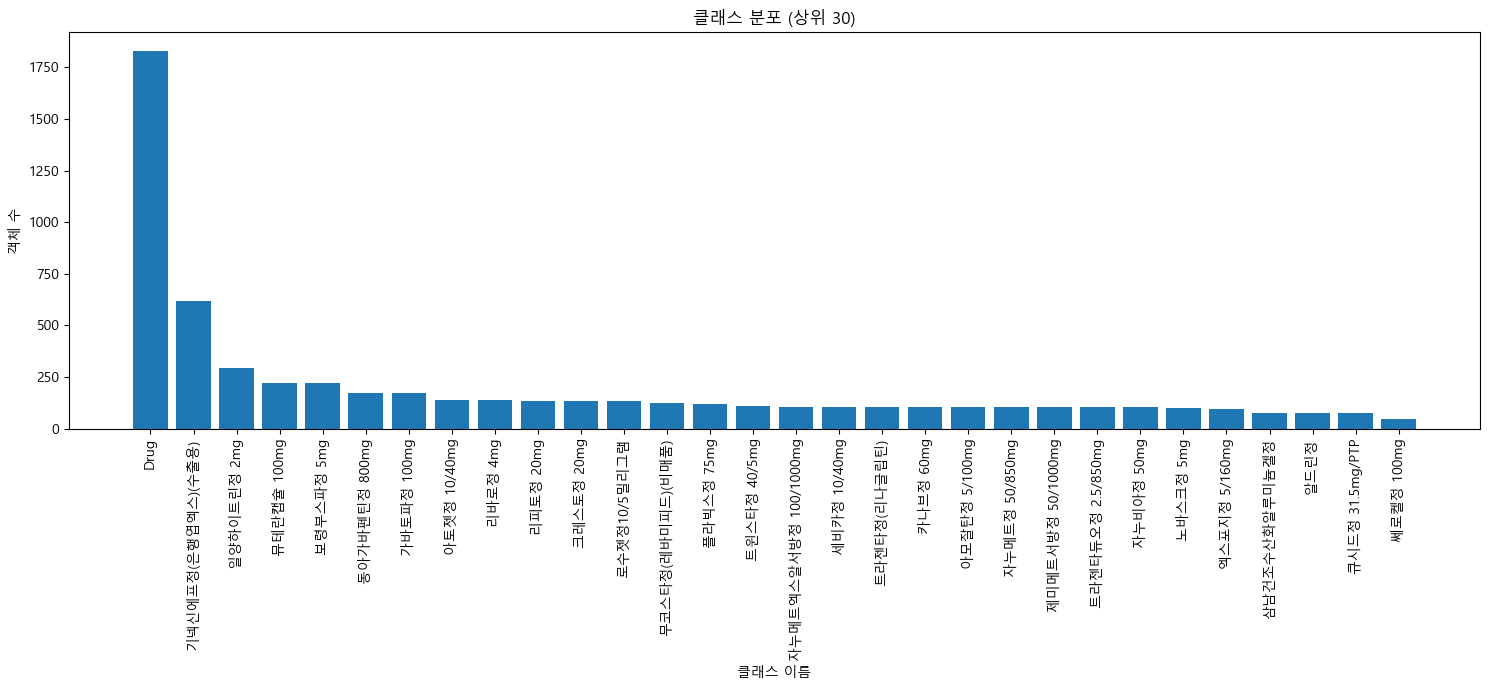

--- 클래스 분포 (하위 30) ---


name  count
0                 렉사프로정 15mg     12
1               자이프렉사정 2.5mg     12
2                졸로푸트정 100mg     12
3                브린텔릭스정 20mg     12
4                 쿠에타핀정 25mg     12
5                아빌리파이정 10mg     18
6             글리틴정(콜린알포세레이트)     27
7   오마코연질캡슐(오메가-3-산에틸에스테르90)     27
8                       마도파정     30
9            아질렉트정(라사길린메실산염)     30
10               리리카캡슐 150mg     30
11    종근당글리아티린연질캡슐(콜린알포세레이트)     30
12         에빅사정(메만틴염산염)(비매품)     30
13                카발린캡슐 25mg     30
14              뉴로메드정(옥시라세탐)     30
15            로수바미브정 10/20mg     30
16                아토르바정 10mg     30
17                리피로우정 20mg     30
18                 글리아타민연질캡슐     30
19           콜리네이트연질캡슐 400mg     30
20                 스토가정 10mg     36
21                 케이캡정 50mg     36
22               에스원엠프정 20mg     36
23            란스톤엘에프디티정 30mg     36
24                라비에트정 20mg     36
25                  놀텍정 10mg     36
26           리렉스펜정 300mg/PTP     39
27             비모보정 500/20mg     42
28              에어탈정(아세클로페낙)     42
29                      레일라정     42

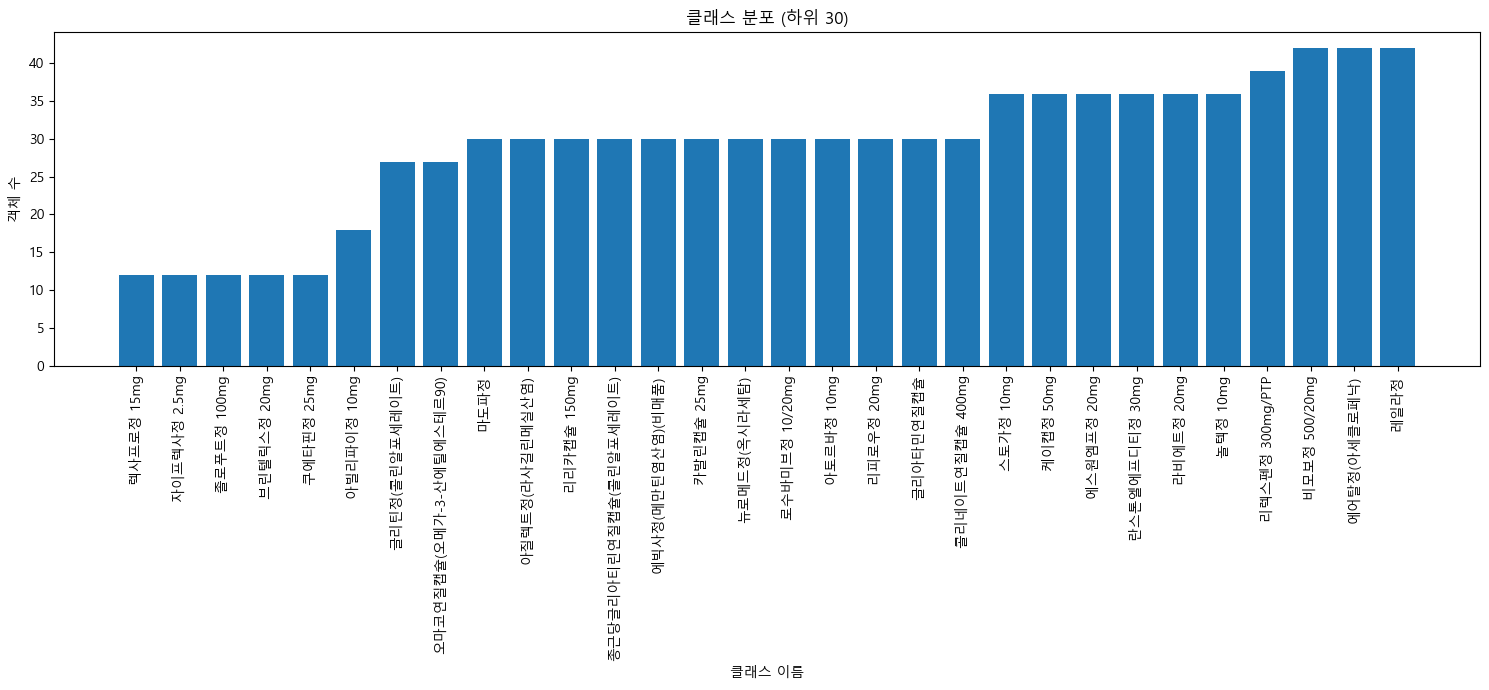

In [4]:
# ================================================================
# [1.2] 클래스 분포 (이름 우선, 없으면 id 대표명)
# ================================================================
"""
클래스별 객체 수 집계 표/막대그래프.
- 기준 : category_name > category_id→name > id:K 순으로 표기.
- 출력물 : df_classes(상위 20 표시), 상위 30 클래스 바차트.
"""
def ann_to_name(ann):
    if ann.get("category_name"):
        return ann["category_name"]
    return cat_id_rep_name.get(ann.get("category_id"), f"id:{ann.get('category_id')}")

names = [ann_to_name(a) for a in all_annotations]
class_counts = Counter(names)
df_classes = (pd.DataFrame({"name": list(class_counts.keys()), "count": list(class_counts.values())})
              .sort_values("count", ascending=False).reset_index(drop=True))

print("--- 클래스 분포 (상위 30) ---")
display(df_classes.head(30))

plt.figure(figsize=(15, 7))
plt.bar(df_classes["name"][:30], df_classes["count"][:30])
plt.xticks(rotation=90)
plt.xlabel("클래스 이름"); plt.ylabel("객체 수")
plt.title("클래스 분포 (상위 30)")
plt.tight_layout(); plt.show()

# ================================================================
# [1.2b] 클래스 분포 (하위 20)
# ================================================================
"""
하위(희소) 클래스 20개 표/막대그래프.
- df_classes를 이용해 최하단 20개를 추출
- 전체 클래스가 20개 미만이면 가능한 만큼만 표시
"""
tail_n = min(30, len(df_classes))
df_tail20 = (df_classes.sort_values("count", ascending=True)
                        .head(tail_n)
                        .reset_index(drop=True))

print("--- 클래스 분포 (하위 30) ---")
display(df_tail20)

plt.figure(figsize=(15, 7))
plt.bar(df_tail20["name"], df_tail20["count"])
plt.xticks(rotation=90)
plt.xlabel("클래스 이름"); plt.ylabel("객체 수")
plt.title("클래스 분포 (하위 30)")
plt.tight_layout(); plt.show()

### [1.3] BBox 정합성/이상치 리포트 (면적·겹침·중복·경계 밖)

In [5]:
# ================================================================
# [1.3] BBox 정합성/이상치 리포트
#  - zero/neg size
#  - 이미지 경계 바깥
#  - 면적 분위(1/99) 밖
#  - 높은 겹침(IoU>0.7)
#  - 완전 동일 중복 박스
# ================================================================
"""
박스 품질 점검(알약 다중객체 데이터에 특화)
기준
- Zero/neg 크기: w<=0 or h<=0.
- 경계 밖: (x<0 or y<0 or x+w>W or y+h>H).
- 면적 이상치: 전체 bbox 면적의 1/99 분위 바깥.
- 높은 겹침: IoU > 0.7 (중복 라벨/과탐 후보).
- 중복 bbox: 동일 좌표(소수점 둘째자리 반올림) 반복.
- 출력물: df_suspicious(file_name, ann_id, reason).경계 밖: (x<0 or y<0 or x+w>W or y+h>H).
"""
def iou_xywh(b1, b2):
    x1,y1,w1,h1 = b1; x2,y2,w2,h2 = b2
    xi1, yi1 = max(x1,x2), max(y1,y2)
    xi2, yi2 = min(x1+w1, x2+w2), min(y1+h1, y2+h2)
    inter = max(0.0, xi2-xi1) * max(0.0, yi2-yi1)
    union = w1*h1 + w2*h2 - inter
    return float(inter/union) if union>0 else 0.0

valid_anns = [a for a in all_annotations if isinstance(a.get("bbox"), (list,tuple)) and len(a["bbox"])==4]
areas = [a["bbox"][2]*a["bbox"][3] for a in valid_anns]
lo, hi = (np.percentile(areas, 1), np.percentile(areas, 99)) if areas else (0.0, float("inf"))

rows = []
for fn, anns in tqdm(img_to_anns.items(), desc="이상치 검색"):
    # 이미지 크기 (가능한 경우 경계 검사)
    W = img_info.get(fn, {}).get("width"); H = img_info.get(fn, {}).get("height")

    # (A) zero/neg, 경계 밖, 면적 이상치
    seen = set()
    for a in anns:
        x,y,w,h = a["bbox"]
        reason = []
        if w<=0 or h<=0:
            reason.append("Non-positive WH")
        if W and H:
            if x<0 or y<0 or (x+w)>W or (y+h)>H:
                reason.append("Out-of-bounds")
        area = w*h
        if area<lo or area>hi:
            reason.append(f"Area outlier (area={area:.0f})")
        if reason:
            rows.append({"file_name": fn, "ann_id": a.get("id",-1), "reason": ", ".join(reason)})

    # (B) 동일 중복 박스
    for a in anns:
        key = tuple(round(v,2) for v in a["bbox"])
        if key in seen:
            rows.append({"file_name": fn, "ann_id": a.get("id",-1), "reason": "Duplicate bbox"})
        seen.add(key)

    # (C) 높은 겹침
    for i in range(len(anns)):
        for j in range(i+1, len(anns)):
            iou = iou_xywh(anns[i]["bbox"], anns[j]["bbox"])
            if iou>0.7:
                rows.append({"file_name": fn,
                             "ann_id": f"{anns[i].get('id',-1)}&{anns[j].get('id',-1)}",
                             "reason": f"High overlap IoU={iou:.2f}"})

df_suspicious = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
print(f"의심 어노테이션 수: {len(df_suspicious)}")
display(df_suspicious.head(20))


이상치 검색: 100%|██████████| 2023/2023 [00:00<00:00, 78608.47it/s]

의심 어노테이션 수: 182


file_name ann_id  \
0   K-001900-003544-004543-016551_0_2_0_2_75_000_2...    1&1   
1   K-001900-003544-006563-016548_0_2_0_2_70_000_2...      1   
2   K-001900-003544-006563-016548_0_2_0_2_70_000_2...    1&1   
3   K-001900-003544-016548-021026_0_2_0_2_70_000_2...    1&1   
4   K-001900-003544-016548-027926_0_2_0_2_75_000_2...      1   
5   K-001900-003544-016548-027926_0_2_0_2_90_000_2...      1   
6   K-001900-003544-016548-029345_0_2_0_2_70_000_2...    1&1   
7   K-001900-003544-016548-029345_0_2_0_2_75_000_2...      1   
8   K-001900-003544-016548-029345_0_2_0_2_75_000_2...    1&1   
9   K-001900-003544-016551-029345_0_2_0_2_75_000_2...      1   
10  K-001900-003544-016551-029451_0_2_0_2_70_000_2...    1&1   
11  K-001900-003544-016551-029451_0_2_0_2_90_000_2...    1&1   
12  K-001900-004543-010224-016548_0_2_0_2_75_000_2...      1   
13  K-001900-004543-010224-016548_0_2_0_2_75_000_2...    1&1   
14  K-001900-004543-016548-019607_0_2_0_2_70_000_2...      1   
15  K-001900-004543-016548-019607_0_2_0_2_75_000_2...      1   
16  K-001900-004543-016548-019607_0_2_0_2_90_000_2...      1   
17  K-001900-004543-016548-024850_0_2_0_2_90_000_2...      1   
18  K-001900-004543-016548-024850_0_2_0_2_90_000_2...    1&1   
19  K-001900-004543-016551-019607_0_2_0_2_70_000_2...      1   

                       reason  
0       High overlap IoU=0.70  
1              Duplicate bbox  
2       High overlap IoU=1.00  
3       High overlap IoU=0.97  
4   Area outlier (area=25273)  
5   Area outlier (area=25250)  
6       High overlap IoU=0.98  
7   Area outlier (area=25273)  
8       High overlap IoU=0.74  
9   Area outlier (area=25074)  
10      High overlap IoU=0.98  
11      High overlap IoU=0.74  
12             Duplicate bbox  
13      High overlap IoU=1.00  
14  Area outlier (area=24160)  
15  Area outlier (area=25120)  
16  Area outlier (area=24327)  
17             Duplicate bbox  
18      High overlap IoU=1.00  
19  Area outlier (area=23950)

### [1.4] 이상치 시각화 (랜덤 10장)

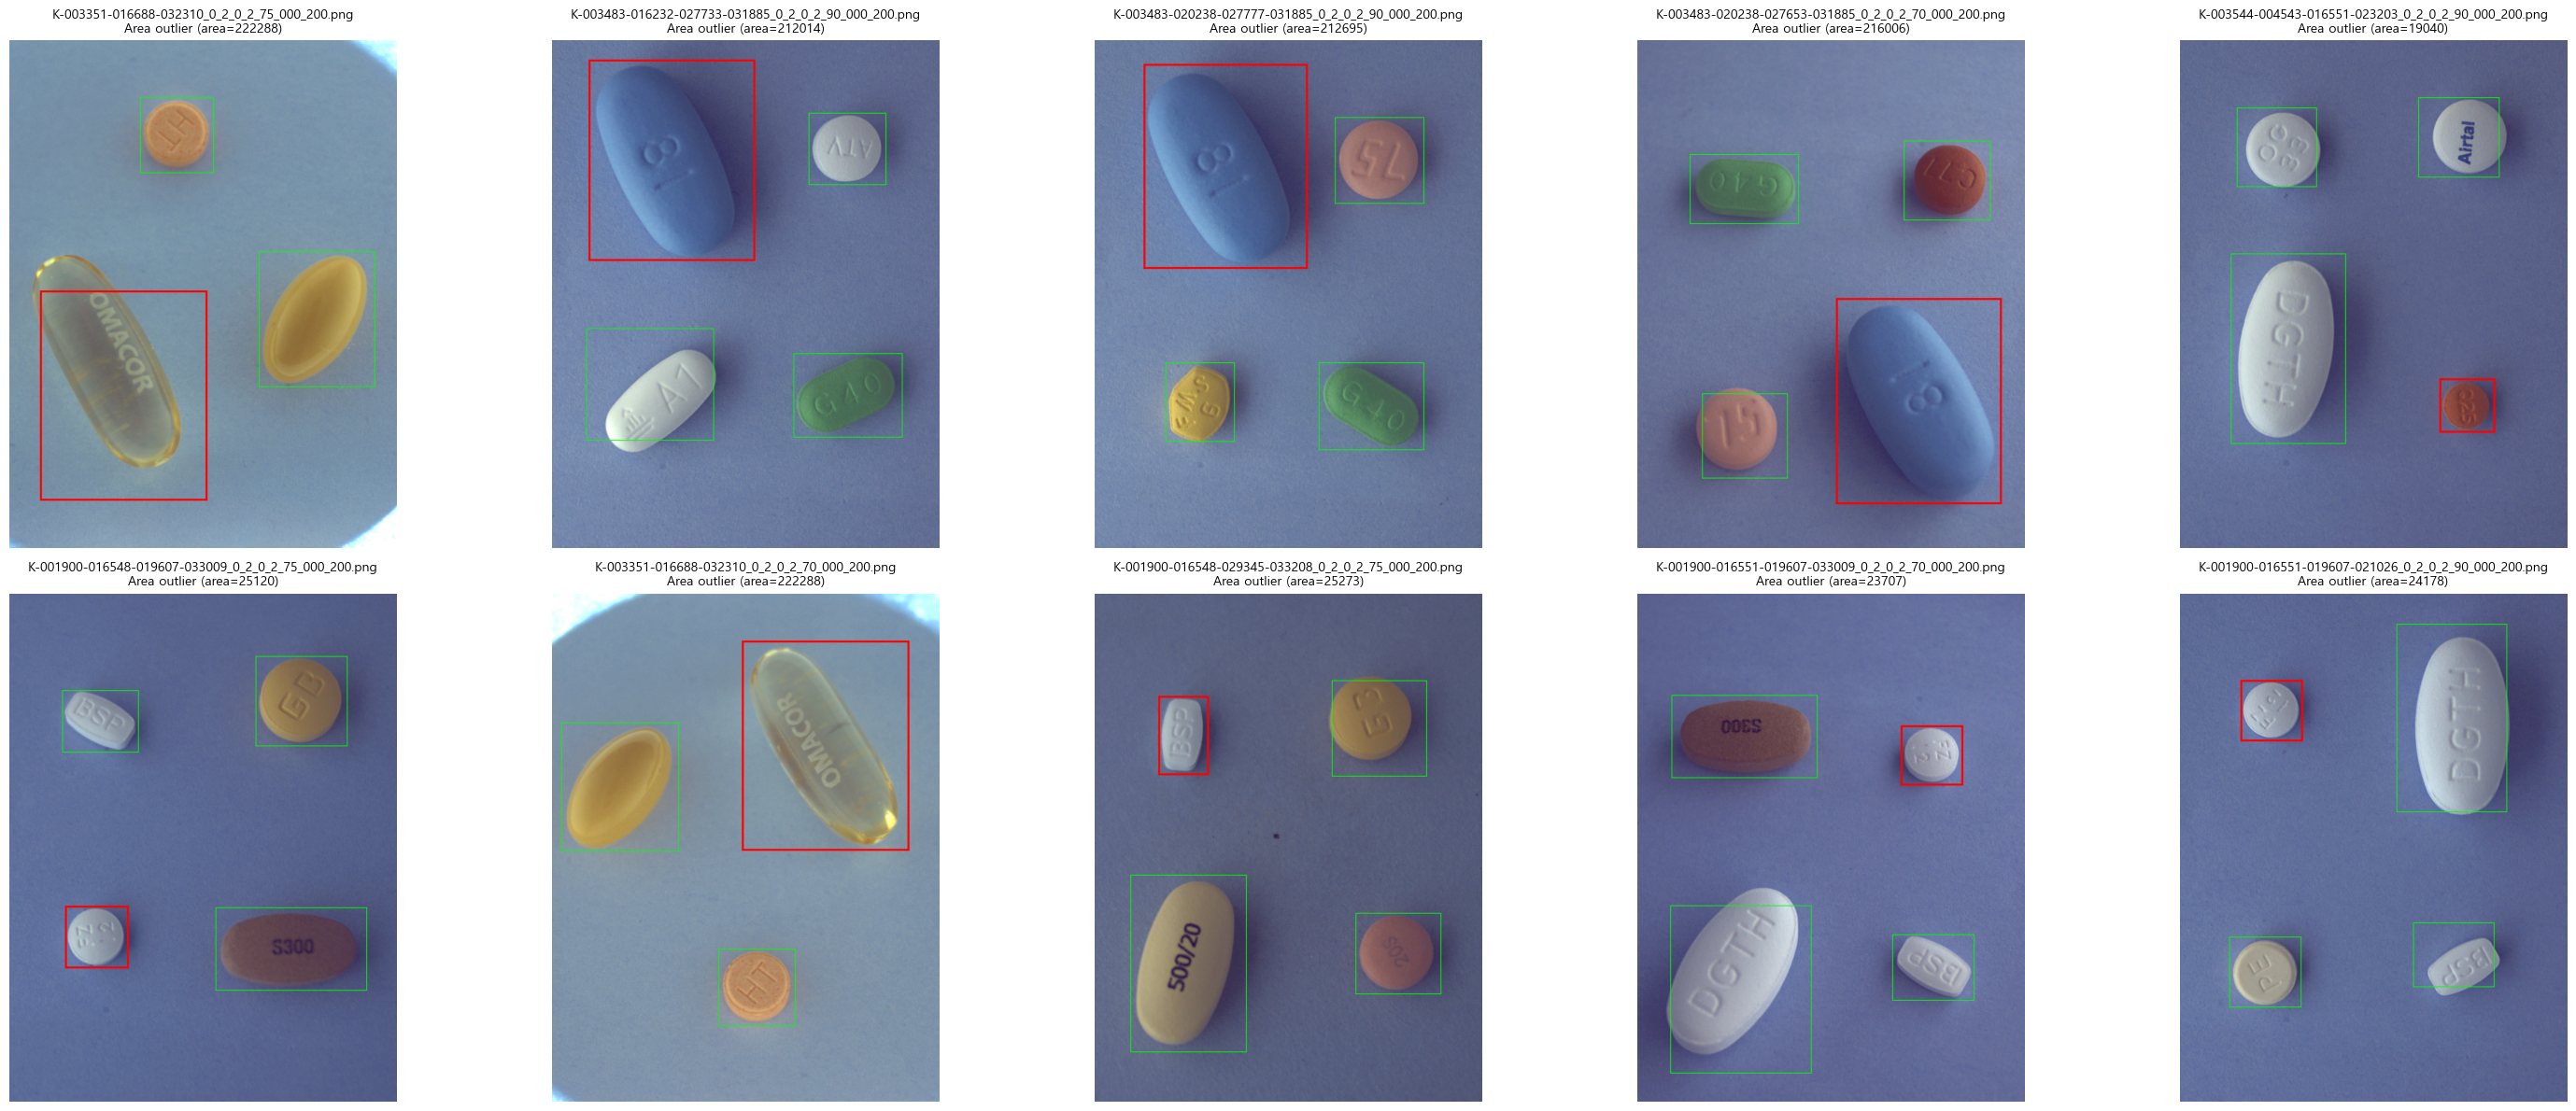

In [6]:
# ================================================================
# [1.4] 이상치 시각화 (랜덤 10장)
#  - 빨강: 의심 bbox, 초록: 정상 bbox
# ================================================================
"""
랜덤 10장에 bbox 오버레이(빨강=의심, 초록=정상).
- 기준: [1.3]에서 모인 의심 ann 기준.
- 출력물: 썸네일 그리드 시각화.
"""
if not df_suspicious.empty:
    flagged = defaultdict(lambda: {"ids": set(), "reasons": set()})
    for _, r in df_suspicious.iterrows():
        fn = r["file_name"]
        flagged[fn]["reasons"].add(r["reason"])
        # 복합 id 처리
        for tok in str(r["ann_id"]).replace("&", " ").split():
            if tok.strip().isdigit():
                flagged[fn]["ids"].add(int(tok.strip()))

    sample = random.sample(list(flagged.keys()), k=min(10, len(flagged)))
    cols = 5; rows = math.ceil(len(sample)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6)); axes=np.array(axes).ravel()

    for i, fn in enumerate(sample):
        p = IMG_DIR / fn
        if not p.exists():
            axes[i].set_title(f"{fn}\n(not found)"); axes[i].axis("off"); continue
        img = Image.open(p).convert("RGB"); dr = ImageDraw.Draw(img)
        bad_ids = flagged[fn]["ids"]

        for a in img_to_anns.get(fn, []):
            x,y,w,h = a["bbox"]; aid = a.get("id",-1)
            color = "red" if aid in bad_ids else "lime"
            width = 5 if color=="red" else 2
            dr.rectangle([x,y,x+w,y+h], outline=color, width=width)

        axes[i].imshow(img)
        axes[i].set_title(f"{fn}\n" + "\n".join(list(flagged[fn]["reasons"])[:3]), fontsize=10)
        axes[i].axis("off")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout(); plt.show()
else:
    print("시각화할 이상치가 없습니다.")


### [1.5] 공간적 분포(히트맵) + 원본 라벨 샘플

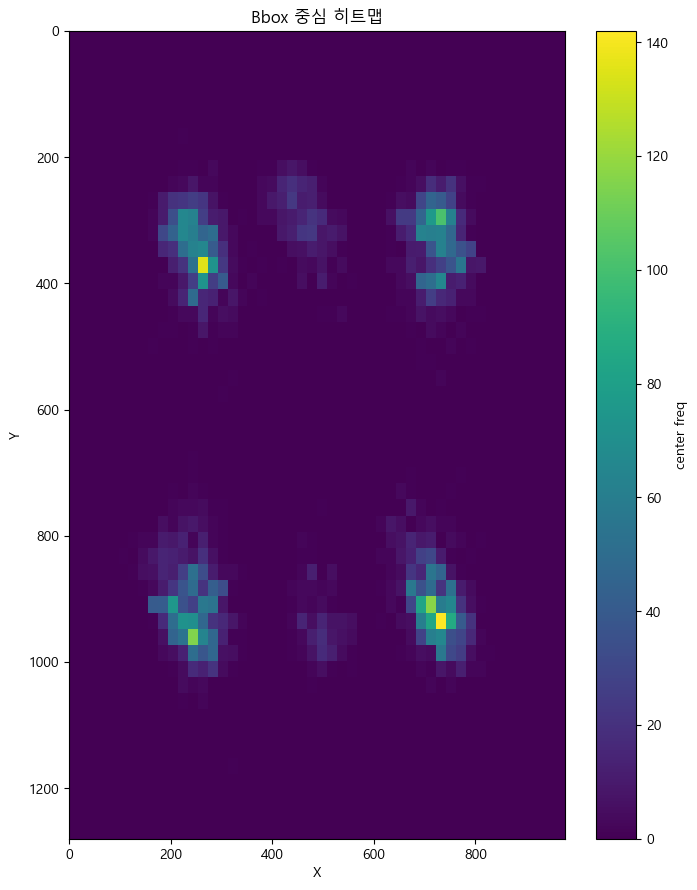

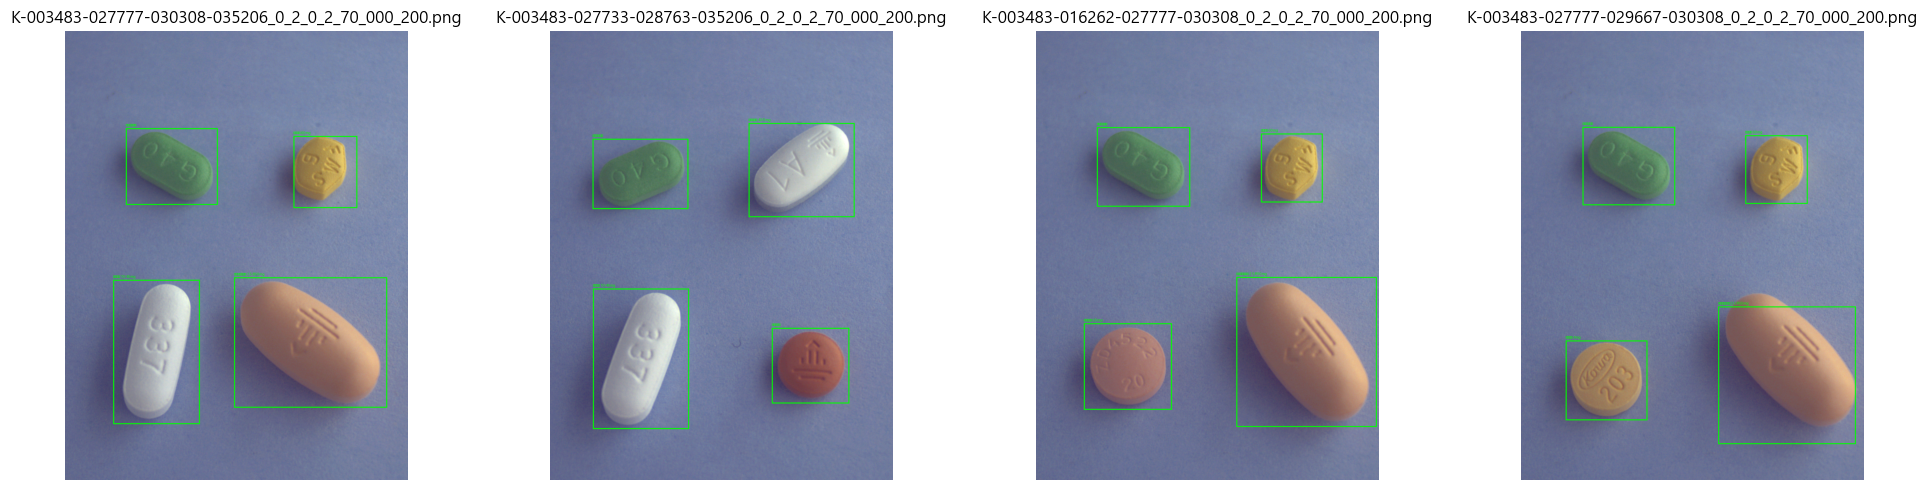

In [7]:
# ================================================================
# [1.5] 공간 히트맵 + 원본 라벨 샘플
# ================================================================
"""
- 히트맵: bbox 중심점 분포(평균 이미지 크기 범위로 정규화된 캔버스).
- 샘플 4장: 원본 라벨 오버레이(클래스명 텍스트).
- 기준: 이미지 크기 정보가 충분할 때 히트맵 범위 사용.
- 출력물: 2D 히스토그램, 샘플 썸네일.
"""
valid = [a for a in all_annotations if isinstance(a.get("bbox"), (list,tuple)) and len(a["bbox"])==4]
centers_x = [a["bbox"][0] + a["bbox"][2]/2 for a in valid]
centers_y = [a["bbox"][1] + a["bbox"][3]/2 for a in valid]

# 평균 크기 기반 범위
Ws = [v.get("width")  for v in img_info.values() if v.get("width")]
Hs = [v.get("height") for v in img_info.values() if v.get("height")]
if Ws and Hs:
    avgW, avgH = float(np.mean(Ws)), float(np.mean(Hs))
    plt.figure(figsize=(8, 8*(avgH/max(avgW,1e-6))))
    plt.hist2d(centers_x, centers_y, bins=[50,50], range=[[0,avgW],[0,avgH]])
    plt.colorbar(label="center freq")
    plt.gca().invert_yaxis()
    plt.title("Bbox 중심 히트맵"); plt.xlabel("X"); plt.ylabel("Y")
    plt.show()
else:
    print("이미지 크기 정보가 부족해 히트맵 범위를 지정하지 않았습니다.")

# 샘플 4장 라벨 오버레이
if img_to_anns:
    sample = random.sample(list(img_to_anns.keys()), k=min(4, len(img_to_anns)))
    fig, axes = plt.subplots(1, len(sample), figsize=(5*len(sample),5))
    if len(sample)==1: axes=[axes]
    for ax, fn in zip(axes, sample):
        p = IMG_DIR / fn
        if not p.exists():
            ax.set_title(f"{fn} (not found)"); ax.axis("off"); continue
        img = Image.open(p).convert("RGB"); dr = ImageDraw.Draw(img)
        for a in img_to_anns[fn]:
            x,y,w,h = a["bbox"]
            # 라벨 텍스트
            cname = a.get("category_name") or cat_id_rep_name.get(a.get("category_id"), "Unknown")
            dr.rectangle([x,y,x+w,y+h], outline="lime", width=3)
            try:
                dr.text((x, max(0,y-15)), str(cname).split("(")[0].strip(), fill="lime")
            except Exception:
                pass
        ax.imshow(img); ax.set_title(fn); ax.axis("off")
    plt.tight_layout(); plt.show()


### [1.6] 이미지당 객체 수 분포

평균: 3.67  | 최소: 2  | 최대: 6
--- 개수별 이미지 수 ---
2개: 7 장
3개: 669 장
4개: 1329 장
5개: 13 장
6개: 5 장


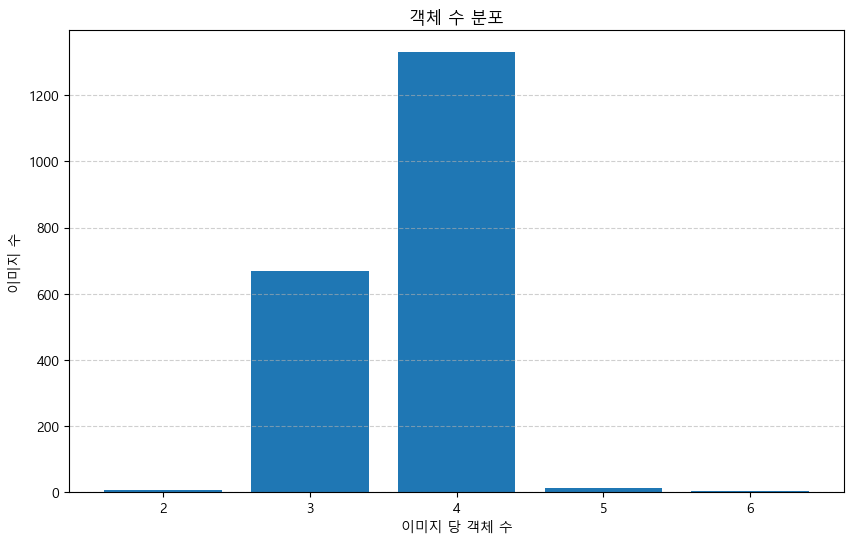

In [8]:
# ================================================================
# [1.6] 이미지당 객체(알약) 수 분포
# ================================================================
"""
이미지별 bbox 개수 통계.
- 기준: img_to_anns[file_name] 길이 기준.
- 출력물: 평균/최소/최대 + 개수별 이미지 수 바차트.
"""
counts = [len(v) for v in img_to_anns.values()]
if counts:
    dist = Counter(counts)
    print(f"평균: {np.mean(counts):.2f}  | 최소: {np.min(counts)}  | 최대: {np.max(counts)}")
    print("--- 개수별 이미지 수 ---")
    for k in sorted(dist):
        print(f"{k}개: {dist[k]} 장")

    plt.figure(figsize=(10,6))
    plt.bar(list(dist.keys()), list(dist.values()))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.xlabel("이미지 당 객체 수"); plt.ylabel("이미지 수"); plt.title("객체 수 분포")
    plt.xticks(sorted(dist.keys()))
    plt.show()
else:
    print("어노테이션이 없어 통계를 계산할 수 없습니다.")


### [1.7] 이미지 품질(선명도) 분포 — Laplacian variance

선명도 샘플 이미지 수: 500


선명도 계산: 100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


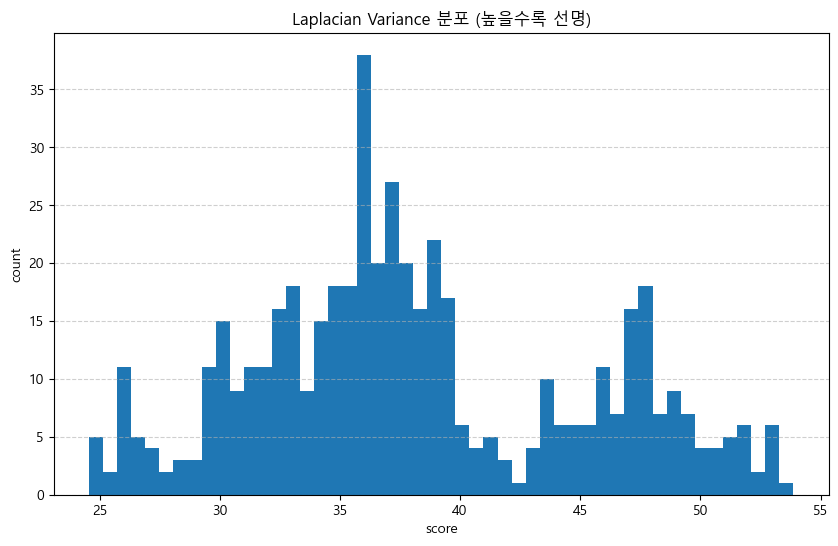

평균 선명도: 38.16 | 흐릿(<100) 비율: 100.00% (500/500)


In [9]:
# ================================================================
# [1.7] 이미지 품질(선명도) — Laplacian Variance
# ================================================================
"""
Laplacian Variance로 선명도 분포(샘플 최대 500장).
- 기준: 흐릿 판단 임계치 예시 score < 100.
- 무엇: Laplacian Variance로 선명도 분포(샘플 최대 500장).
"""
import cv2

all_paths = [p for p in IMG_DIR.iterdir() if p.suffix.lower() in IMAGE_EXTS]
sample_paths = random.sample(all_paths, k=min(500, len(all_paths)))
print(f"선명도 샘플 이미지 수: {len(sample_paths)}")

scores = []
for p in tqdm(sample_paths, desc="선명도 계산"):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    scores.append(float(cv2.Laplacian(img, cv2.CV_64F).var()))

if scores:
    plt.figure(figsize=(10,6))
    plt.hist(scores, bins=50)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.title("Laplacian Variance 분포 (높을수록 선명)")
    plt.xlabel("score"); plt.ylabel("count")
    plt.show()

    thr = 100.0
    blurry = sum(1 for s in scores if s < thr)
    print(f"평균 선명도: {np.mean(scores):.2f} | 흐릿(<{thr:.0f}) 비율: {blurry/len(scores)*100:.2f}% ({blurry}/{len(scores)})")
else:
    print("선명도 점수를 계산할 수 없습니다.")


### [1.8] 클래스별 bbox 크기 프로파일 & 소형/중형/대형 비율

In [10]:
# ================================================================
# [1.8] (패치) 클래스별 bbox 크기 프로파일 (버킷 결측 안전)
# ================================================================
"""
bbox 면적을 **이미지 면적 대비 %**로 정규화하여 S/M/L 비율.
- 기준: S<1%, M 1~5%, L>5%, 이미지 크기 미상은 NA.
- 출력물: summary(S/M/L/NA 컬럼), 상위 20 표시.
(버킷 결측 시 컬럼 보강해 KeyError 방지)
"""
records = []
for fn, anns in img_to_anns.items():
    W = img_info.get(fn,{}).get("width"); H = img_info.get(fn,{}).get("height")
    for a in anns:
        name = a.get("category_name") or cat_id_rep_name.get(a.get("category_id"), f"id:{a.get('category_id')}")
        x,y,w,h = a["bbox"]
        area = w*h
        rec = {"name": name, "area": area}
        if W and H and W > 0 and H > 0:
            rec["area_norm_pct"] = 100.0 * area / (W * H)
        else:
            rec["area_norm_pct"] = np.nan
        records.append(rec)

df = pd.DataFrame(records)

if df.empty:
    print("분석할 bbox가 없습니다.")
else:
    # 소/중/대 기준(정규화 면적 % 기준)
    def size_bucket(p):
        if pd.isna(p): return "NA"
        if p < 1.0:   return "S(<1%)"
        if p < 5.0:   return "M(1~5%)"
        return "L(>5%)"

    df["bucket"] = df["area_norm_pct"].apply(size_bucket)

    # 피벗: 누락 버킷 컬럼도 강제로 생성하여 0으로 채우기
    bucket_order = ["S(<1%)", "M(1~5%)", "L(>5%)", "NA"]
    summary = (df.groupby(["name", "bucket"]).size()
                 .unstack(fill_value=0))

    # 버킷 컬럼 강제 정렬/보강
    for b in bucket_order:
        if b not in summary.columns:
            summary[b] = 0
    summary = summary[bucket_order]

    # 정렬 기준: 존재하는 컬럼만 사용. 없으면 TOTAL로 정렬
    sort_by = [b for b in ["S(<1%)","M(1~5%)","L(>5%)"] if b in summary.columns]
    if sort_by:
        summary = summary.sort_values(by=sort_by, ascending=False)
    else:
        summary["TOTAL"] = summary.sum(axis=1)
        summary = summary.sort_values(by="TOTAL", ascending=False).drop(columns=["TOTAL"])

    print("=== 클래스별 S/M/L 비율 (상위 20) ===")
    display(summary.head(20))


=== 클래스별 S/M/L 비율 (상위 20) ===


bucket              S(<1%)  M(1~5%)  L(>5%)  NA
name                                           
Drug                     0      925     895   0
기넥신에프정(은행엽엑스)(수출용)       0      617       0   0
일양하이트린정 2mg              0      289       2   0
보령부스파정 5mg               0      222       0   0
가바토파정 100mg              0      173       1   0
리바로정 4mg                 0      137       0   0
리피토정 20mg                0      134       0   0
로수젯정10/5밀리그램             0      132       0   0
크레스토정 20mg               0      130       3   0
무코스타정(레바미피드)(비매품)        0      122       1   0
플라빅스정 75mg               0      118       2   0
세비카정 10/40mg             0      105       0   0
카나브정 60mg                0      105       0   0
트라젠타정(리나글립틴)             0      105       0   0
자누비아정 50mg               0      102       0   0
노바스크정 5mg                0       98       0   0
쎄로켈정 100mg               0       48       0   0
펠루비정(펠루비프로펜)             0       45       0   0
에어탈정(아세클로페낙)             0       41       1   0
놀텍정 10mg                 0       36       0   0

결과
COCO 원본 EDA 결과 요약 (해석 & 다음 단계)
1. 이미지/주석 규모: 이미지 2,023장 / 어노테이션 7,432개
2. 누락 파일: JSON은 있는데 실제 이미지가 없는 파일 8개
3. 클래스: 총 74개, 단 Drug가 1,828개로 과다(원치 않는 대분류)
4. 이상치: 의심 어노테이션 182건
5. 주로 중복 bbox와 IoU 고중첩(≥0.7), 면적 이상치가 믹스
6. 이미지당 객체 수: 평균 3.67, 대부분 3~4개
7. 선명도: 평균 38.34, 100%가 blur 기준(<100) 아래 → 전반적 흐릿
8. 크기 분포(S/M/L): 대부분 M(1~5%), L(>5%) → 박스가 비교적 큼(알약 개별이 아니라 군집/큰 박스 라벨 가능성)

---
### [2.0] 분할/변환 설정

In [11]:
# ================================================================
# [2.0] 분할/변환 설정 (견고화)
# ================================================================
from pathlib import Path
import os, json, shutil
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# ---- 소스(COCO) 경로: 이미 EDA에서 쓰던 동일 경로 ----
DATA_NEW = Path("D:/datasets/data_new")
IMG_DIR  = DATA_NEW / "train_images"
ANN_DIR  = DATA_NEW / "train_annotations"

assert IMG_DIR.exists(), f"이미지 폴더 없음: {IMG_DIR}"
assert ANN_DIR.exists(), f"어노 폴더 없음: {ANN_DIR}"

# ---- 산출(YOLO) 루트 ----
YOLO_ROOT = Path("D:/datasets/data_yolo")          # ← 팀 공통 경로로 합의 권장
IM_OUT    = YOLO_ROOT / "images"
LB_OUT    = YOLO_ROOT / "labels"

# ---- 정책 스위치 ----
# 85클래스 유지하려면 False (Drug 포함)
# Drug 같은 대분류를 제외해 73클래스로 만들려면 True
EXCLUDE_GENERIC = False
GENERIC_NAMES   = {"Drug"}   # 제외 대상 이름 집합
VAL_RATIO       = 0.20
RANDOM_STATE    = 42

# ---- 출력 디렉토리 준비 ----
for p in [IM_OUT/"train", IM_OUT/"val", LB_OUT/"train", LB_OUT/"val"]:
    p.mkdir(parents=True, exist_ok=True)

print("✅ 변환 출력 경로:", YOLO_ROOT)
print(f"정책 ▶ EXCLUDE_GENERIC={EXCLUDE_GENERIC}, GENERIC_NAMES={GENERIC_NAMES}, VAL_RATIO={VAL_RATIO}")
print(f"소스 ▶ IMG_DIR={IMG_DIR.name}, ANN_DIR={ANN_DIR.name}")


✅ 변환 출력 경로: D:\datasets\data_yolo
정책 ▶ EXCLUDE_GENERIC=False, GENERIC_NAMES={'Drug'}, VAL_RATIO=0.2
소스 ▶ IMG_DIR=train_images, ANN_DIR=train_annotations


### [2.1] 분할을 위한 테이블 구성 (파일명/그룹/어노 개수)

In [12]:
# ================================================================
# [2.1] 분할 테이블 구성
#  - file_name, group, ann_count(원본 기준, EXCLUDE_GENERIC 무시)
#  - 실제 존재하는 이미지 기준
# ================================================================
from pathlib import Path
import pandas as pd

# --- 선행 산출물: EDA 1.x에서 만든 img_to_anns 가정 ---
#     없으면 아주 가볍게 재구성(폴백)하도록 가드.
def _rebuild_img_to_anns(ann_dir: Path):
    img_to_anns = {}
    for jf in ann_dir.rglob("*.json"):
        try:
            data = json.loads(jf.read_text(encoding="utf-8"))
        except:
            data = json.loads(jf.read_text(encoding="cp949", errors="ignore"))
        images = data.get("images") or []
        anns   = data.get("annotations") or []
        id2fn  = {im.get("id"): im.get("file_name") for im in images if im.get("file_name") is not None}
        for a in anns:
            fn = id2fn.get(a.get("image_id"))
            if not fn: 
                continue
            img_to_anns.setdefault(fn, []).append(a)
    return img_to_anns

# 기존 변수 있으면 사용, 없으면 폴백
if "img_to_anns" not in globals() or not isinstance(img_to_anns, dict) or len(img_to_anns)==0:
    print("ℹ️ img_to_anns가 없어 ANN_DIR에서 간이 재구성합니다.")
    img_to_anns = _rebuild_img_to_anns(ANN_DIR)

def extract_group_key(file_name: str) -> str:
    """
    예: K-001900-003544-016548-029345_0_2_0_2_75_000_200.png
      → K-001900-003544-016548-029345
    """
    s = str(file_name)
    pos = s.find("_")
    return s[:pos] if pos > 0 else s.rsplit(".", 1)[0]

# 실제 존재하는 이미지 목록
img_exts = {".png", ".jpg", ".jpeg", ".bmp"}
existing_imgs = {p.name for p in IMG_DIR.iterdir() if p.suffix.lower() in img_exts}

# img_to_anns 중 실존 이미지만
valid_fns = sorted([fn for fn in img_to_anns.keys() if fn in existing_imgs])

rows = []
for fn in valid_fns:
    rows.append({
        "file_name": fn,
        "group": extract_group_key(fn),
        "ann_count": len(img_to_anns.get(fn, [])),   # 원본 ann 개수(Drug 포함/제외 무관)
    })

df_split = (pd.DataFrame(rows)
            .drop_duplicates(subset=["file_name"])
            .sort_values("file_name")
            .reset_index(drop=True))

print("샘플 5행:")
display(df_split.head())
print(f"고유 그룹 수: {df_split['group'].nunique()} | 이미지 수: {len(df_split)}")

# 참고: JSON에는 있는데 실제 이미지가 없는 케이스(있다면 상위 10)
excluded = sorted(set(img_to_anns.keys()) - existing_imgs)
if excluded:
    print(f"⚠️ JSON↔이미지 불일치로 제외된 파일 수: {len(excluded)} (예시 10)")
    print(excluded[:10])


샘플 5행:


file_name  \
0  K-001866-013395-022627-044834_0_2_0_2_70_000_2...   
1  K-001866-013395-022627-044834_0_2_0_2_75_000_2...   
2  K-001866-013395-022627-044834_0_2_0_2_90_000_2...   
3  K-001866-013395-023223-037777_0_2_0_2_70_000_2...   
4  K-001866-013395-023223-037777_0_2_0_2_75_000_2...   

                           group  ann_count  
0  K-001866-013395-022627-044834          4  
1  K-001866-013395-022627-044834          4  
2  K-001866-013395-022627-044834          4  
3  K-001866-013395-023223-037777          4  
4  K-001866-013395-023223-037777          4

고유 그룹 수: 677 | 이미지 수: 2023


### [2.2] 그룹 기반 train/val 분할

In [13]:
# ================================================================
# [2.2] 그룹 기반 train/val 분할 (GroupShuffleSplit)
# ================================================================
"""
그룹 누수 방지(동일 그룹이 train/val에 섞이지 않게).
- GroupShuffleSplit(test_size=VAL_RATIO, random_state=42)
- group 컬럼 기준으로 index split

검사 기준
- len(train), len(val) 비율
- 그룹 교차 개수 = 0이어야 정상
- 출력: df_train, df_val (파일명 목록).
"""
from sklearn.model_selection import GroupShuffleSplit


gss = GroupShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=RANDOM_STATE)
groups = df_split["group"].values
idx = np.arange(len(df_split))
train_idx, val_idx = next(gss.split(idx, groups=groups))

df_train = df_split.iloc[train_idx].copy()
df_val   = df_split.iloc[val_idx].copy()

print("train 이미지:", len(df_train), " | val 이미지:", len(df_val))
print("그룹 교차 여부(0=정상):", len(set(df_train["group"]) & set(df_val["group"])))


train 이미지: 1616  | val 이미지: 407
그룹 교차 여부(0=정상): 0


### [2.3] YOLO 클래스 목록/ID 매핑 생성 (Drug 정책 반영)

In [14]:
# ================================================================
# [2.3] (대체 버전) 팀 YAML(85개) 고정 names를 기준으로 매핑 생성
# ================================================================
import yaml

TEAM_YAML = Path("../configs/yolo_data.yaml")  # 팀이 쓰던 85-class YAML 경로
if not TEAM_YAML.exists():
    raise FileNotFoundError(f"팀 YAML을 찾을 수 없어요: {TEAM_YAML}")

cfg = yaml.safe_load(TEAM_YAML.read_text(encoding="utf-8"))
team_names = cfg.get("names")
if not isinstance(team_names, list) or len(team_names) < 1:
    raise ValueError("팀 YAML의 names를 읽지 못했습니다.")

# 1) 팀 names를 그대로 classes.txt로 고정 (길이가 85여야 함)
class_names = [str(n).strip() for n in team_names]
(YOLO_ROOT / "classes.txt").write_text("\n".join(class_names), encoding="utf-8")

# 2) 이름→YOLO id 인덱스 사전
name_to_yid = {name: i for i, name in enumerate(class_names)}

# 3) COCO cat_id → 대표이름(cat_id_rep_name) → 팀 names 인덱스로 매핑
#    - 대표이름이 팀 names에 없으면 스킵(그 클래스는 변환 시 라벨이 안 생김)
yolo_id_map = {}
missing_in_team = set()

# 분할에 속한 이미지들만 사용
in_trainval = set(df_train["file_name"]) | set(df_val["file_name"])

def _rep_name_from_ann(a):
    return a.get("category_name") or cat_id_rep_name.get(a.get("category_id"), "")

used_cids = set()
for fn, anns in img_to_anns.items():
    if fn not in in_trainval:
        continue
    for a in anns:
        cid = a.get("category_id")
        if cid is None: 
            continue
        rep = _rep_name_from_ann(a)
        # Drug도 포함시키고 싶다면 EXCLUDE_GENERIC는 이후 write_yolo_label에서 False로 유지
        if not rep:
            continue
        used_cids.add(cid)
        if rep in name_to_yid:
            yolo_id_map[cid] = name_to_yid[rep]
        else:
            missing_in_team.add(rep)

# 리포트
print(f"[팀 YAML 기준 고정] classes.txt 길이: {len(class_names)} (예: {class_names[:5]})")
print(f"COCO에서 등장했지만 팀 names에 없는 이름 수: {len(missing_in_team)}")
if missing_in_team:
    print("  예시:", list(sorted(missing_in_team))[:10])

# yolo_id_map 저장
import json
with open(YOLO_ROOT / "yolo_id_map.json", "w", encoding="utf-8") as f:
    json.dump({"cat_id_to_yolo_id": yolo_id_map, "class_names": class_names}, f, ensure_ascii=False, indent=2)
print("저장 완료 →", YOLO_ROOT / "yolo_id_map.json")


[팀 YAML 기준 고정] classes.txt 길이: 85 (예: ['가바토파정 100mg', '글리아타민연질캡슐', '글리틴정(콜린알포세레이트)', '기넥신에프정(은행엽엑스)(수출용)', '낙소졸정 500/20mg'])
COCO에서 등장했지만 팀 names에 없는 이름 수: 1
  예시: ['Drug']
저장 완료 → D:\datasets\data_yolo\yolo_id_map.json


### [2.4] COCO → YOLO 변환 함수 (bbox 변환 + .txt 생성)

In [15]:
# ================================================================
# [2.4] 변환 함수 (COCO xywh[pixel] → YOLO cx,cy,w,h[0..1])
# ================================================================
def coco_xywh_to_yolo_cxcywh(x, y, w, h, W, H):
    cx = (x + w / 2.0) / max(W, 1e-9)
    cy = (y + h / 2.0) / max(H, 1e-9)
    nw = w / max(W, 1e-9)
    nh = h / max(H, 1e-9)
    return cx, cy, nw, nh

def write_yolo_label(txt_path, anns, W, H, yolo_id_map, exclude_generic=True):
    lines = []
    for a in anns:
        cid = a.get("category_id")
        if cid is None:
            continue
        cname = a.get("category_name") or cat_id_rep_name.get(cid, "")
        if exclude_generic and cname in GENERIC_NAMES:
            continue
        if cid not in yolo_id_map:
            continue
        x, y, w, h = a.get("bbox", [0,0,0,0])
        if w <= 0 or h <= 0:
            continue
        cx, cy, nw, nh = coco_xywh_to_yolo_cxcywh(x, y, w, h, W, H)
        if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 < nw <= 1 and 0 < nh <= 1):
            continue
        yid = yolo_id_map[cid]
        lines.append(f"{yid} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")
    txt_path.write_text("\n".join(lines), encoding="utf-8")


In [16]:
# ================================================================
# [2.5] 파일 생성 (images/train|val, labels/train|val)
# ================================================================
import shutil
from tqdm.auto import tqdm
from pathlib import Path

# 전제: IMG_DIR, IM_OUT, LB_OUT, df_train, df_val, img_to_anns, img_info, yolo_id_map, EXCLUDE_GENERIC
required = ["IMG_DIR", "IM_OUT", "LB_OUT", "df_train", "df_val", "img_to_anns", "img_info", "yolo_id_map", "EXCLUDE_GENERIC"]
for v in required:
    if v not in globals():
        raise NameError(f"[2.5] '{v}' 가 정의되어 있지 않습니다. 앞 단계 셀을 먼저 실행하세요.")

def materialize_split(df, split):
    im_dir = IM_OUT / split
    lb_dir = LB_OUT / split
    im_dir.mkdir(parents=True, exist_ok=True)
    lb_dir.mkdir(parents=True, exist_ok=True)

    copied, labeled = 0, 0
    for fn in tqdm(df["file_name"].tolist(), desc=f"materialize {split}"):
        src_img = IMG_DIR / fn
        if not src_img.exists():
            # 이미지 누락 시 스킵
            continue

        # 이미지 복사
        dst_img = im_dir / fn
        shutil.copy2(src_img, dst_img)
        copied += 1

        # 크기 확보
        W = img_info.get(fn, {}).get("width")
        H = img_info.get(fn, {}).get("height")
        if not (W and H):
            try:
                import cv2
                img = cv2.imread(str(src_img))
                if img is not None:
                    H, W = img.shape[:2]
            except Exception:
                pass
        if not (W and H):
            continue

        # 라벨 생성
        txt_path = (lb_dir / fn).with_suffix(".txt")
        anns = img_to_anns.get(fn, [])
        write_yolo_label(txt_path, anns, W, H, yolo_id_map, exclude_generic=EXCLUDE_GENERIC)
        labeled += 1

    return copied, labeled

tr_copied, tr_labeled = materialize_split(df_train, "train")
va_copied, va_labeled = materialize_split(df_val,   "val")

# 스플릿 파일 저장
(YOLO_ROOT / "split_train.txt").write_text("\n".join(df_train["file_name"].tolist()), encoding="utf-8")
(YOLO_ROOT / "split_val.txt").write_text("\n".join(df_val["file_name"].tolist()), encoding="utf-8")

print(f"train: images {tr_copied}, labels {tr_labeled}")
print(f"val  : images {va_copied}, labels {va_labeled}")


materialize val: 100%|██████████| 407/407 [00:01<00:00, 335.28it/s]

train: images 1616, labels 1616
val  : images 407, labels 407


### [2.6] YOLO 변환 후 무결성 점검 (라벨/클래스/범위)

In [17]:
# ================================================================
# [2.6] YOLO 변환 후 무결성 점검
# ================================================================
def scan_yolo_labels(root: Path):
    used_ids, n_files, bad_lines = set(), 0, 0
    for f in root.rglob("*.txt"):
        if f.name.lower().startswith("classes"):
            continue
        n_files += 1
        for ln in f.read_text(encoding="utf-8", errors="ignore").splitlines():
            ln = ln.strip()
            if not ln:
                continue
            parts = ln.split()
            try:
                yid = int(float(parts[0]))
                vals = list(map(float, parts[1:5]))
                cx, cy, w, h = vals
                if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 < w <= 1 and 0 < h <= 1):
                    bad_lines += 1
                used_ids.add(yid)
            except:
                bad_lines += 1
    return used_ids, n_files, bad_lines

def count_pairs(img_dir: Path, lb_dir: Path):
    imgs = {p.with_suffix("").name for p in img_dir.iterdir() if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp"}}
    lbs  = {p.with_suffix("").name for p in lb_dir.glob("*.txt")}
    missing_labels = sorted(imgs - lbs)[:20]
    extra_labels   = sorted(lbs - imgs)[:20]
    return imgs, lbs, missing_labels, extra_labels

for split in ["train","val"]:
    imgs, lbs, miss, extra = count_pairs(IM_OUT/split, LB_OUT/split)
    print(f"[{split}] images={len(imgs)} labels={len(lbs)}")
    print(f"  - 이미지만 있고 라벨 없는 파일 수: {len(miss)} (예시: {miss[:5]})")
    print(f"  - 라벨만 있고 이미지 없는 파일 수: {len(extra)} (예시: {extra[:5]})")

used_ids_tr, n_tr, bad_tr = scan_yolo_labels(LB_OUT/"train")
used_ids_va, n_va, bad_va = scan_yolo_labels(LB_OUT/"val")
used_ids_total = used_ids_tr | used_ids_va

cls_names = (YOLO_ROOT/"classes.txt").read_text(encoding="utf-8").splitlines()
defined_ids = set(range(len(cls_names)))

print("\n라벨 파일 수(train/val):", n_tr, n_va)
print("사용된 yolo class ids:", sorted(list(used_ids_total))[:20], "...", f"(총 {len(used_ids_total)})")
print("classes.txt 정의 개수:", len(cls_names))
print("정의 밖 사용 ID:", sorted(list(used_ids_total - defined_ids)))
print("정의됐지만 미사용 ID:", sorted(list(defined_ids - used_ids_total))[:20])
print("잘못된 라벨 라인 수(train/val):", bad_tr, bad_va)


[train] images=1942 labels=1942
  - 이미지만 있고 라벨 없는 파일 수: 0 (예시: [])
  - 라벨만 있고 이미지 없는 파일 수: 0 (예시: [])
[val] images=732 labels=732
  - 이미지만 있고 라벨 없는 파일 수: 0 (예시: [])
  - 라벨만 있고 이미지 없는 파일 수: 0 (예시: [])

라벨 파일 수(train/val): 1942 732
사용된 yolo class ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] ... (총 85)
classes.txt 정의 개수: 85
정의 밖 사용 ID: []
정의됐지만 미사용 ID: []
잘못된 라벨 라인 수(train/val): 1 0


### [2.7] 분포 드리프트(Train vs Val) & 전체 대비 비교 (JS Divergence)

In [18]:
# ================================================================
# [2.7] 분포 드리프트 (Train vs Val, JS Divergence)
# ================================================================
import numpy as np

def label_hist(root: Path, num_classes: int):
    counts = np.zeros(num_classes, dtype=np.float64)
    for f in root.rglob("*.txt"):
        if f.name.lower().startswith("classes"):
            continue
        for ln in f.read_text(encoding="utf-8", errors="ignore").splitlines():
            ln = ln.strip()
            if not ln: 
                continue
            try:
                yid = int(float(ln.split()[0]))
                if 0 <= yid < num_classes:
                    counts[yid] += 1
            except:
                pass
    return counts

def js_divergence(p, q, eps=1e-12):
    p = p / max(p.sum(), eps)
    q = q / max(q.sum(), eps)
    m = 0.5 * (p + q)
    def kl(a, b):
        a = np.clip(a, eps, 1)
        b = np.clip(b, eps, 1)
        return np.sum(a * np.log(a / b))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

C = len(cls_names)
h_tr = label_hist(LB_OUT/"train", C)
h_va = label_hist(LB_OUT/"val",   C)

jsd = js_divergence(h_tr, h_va)
print(f"Train vs Val JS Divergence: {jsd:.4f}  (0=동일, ↑=차이 큼)")

delta = (h_tr / max(h_tr.sum(),1e-9)) - (h_va / max(h_va.sum(),1e-9))
top = np.argsort(np.abs(delta))[::-1][:10]
print("분포 차이 Top-10 클래스 (yid, name, train%, val%):")
for i in top:
    print(f"{i:3d}  {cls_names[i]:30s}  {100*h_tr[i]/max(h_tr.sum(),1e-9):6.2f}%  {100*h_va[i]/max(h_va.sum(),1e-9):6.2f}%")


Train vs Val JS Divergence: 0.0098  (0=동일, ↑=차이 큼)
분포 차이 Top-10 클래스 (yid, name, train%, val%):
  3  기넥신에프정(은행엽엑스)(수출용)               10.49%    8.67%
 26  보령부스파정 5mg                        4.15%    5.30%
  7  뉴로메드정(옥시라세탐)                      0.84%    1.97%
 70  트윈스타정 40/5mg                      1.86%    1.18%
  5  노바스크정 5mg                         1.68%    1.09%
  0  가바토파정 100mg                       2.99%    3.55%
 50  자누메트엑스알서방정 100/1000mg             1.77%    1.27%
 54  제미메트서방정 50/1000mg                 1.77%    1.27%
 67  트라젠타듀오정 2.5/850mg                 1.73%    1.31%
 15  로수젯정10/5밀리그램                      2.43%    2.06%


### [3.0] dataset.yaml 생성 (Ultralytics 학습용)

In [19]:
# ================================================================
# [2.8] dataset.yaml 생성 (Ultralytics 학습용)
# ================================================================
import yaml

names = [ln.strip() for ln in (YOLO_ROOT/"classes.txt").read_text(encoding="utf-8").splitlines() if ln.strip()]
data_yaml = {
    # path는 선택. 팀이 상대경로 쓸 거면 생략 가능
    "path": str(YOLO_ROOT).replace("\\", "/"),
    "train": "images/train",
    "val": "images/val",
    "nc": len(names),
    "names": names,
}
yaml_path = YOLO_ROOT / "dataset.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.dump(data_yaml, f, allow_unicode=True, sort_keys=False)

print(f"✅ dataset.yaml 저장: {yaml_path}")
print(f"nc={len(names)} (예: 앞 5개) → {names[:5]}")


✅ dataset.yaml 저장: D:\datasets\data_yolo\dataset.yaml
nc=85 (예: 앞 5개) → ['가바토파정 100mg', '글리아타민연질캡슐', '글리틴정(콜린알포세레이트)', '기넥신에프정(은행엽엑스)(수출용)', '낙소졸정 500/20mg']


---

### [4.0] 경로/유틸

In [20]:
# ================================================================
# [4.0] YOLO 경로/유틸
# ================================================================
from pathlib import Path
import numpy as np, pandas as pd
from collections import Counter, defaultdict

# --- 경로 ---
YOLO_ROOT = Path(r"D:/datasets/data_yolo")
IM_OUT    = YOLO_ROOT / "images"
LB_OUT    = YOLO_ROOT / "labels"

# --- 파일 존재 체크 ---
assert YOLO_ROOT.exists(), f"YOLO_ROOT 없음: {YOLO_ROOT}"
assert (LB_OUT/"train").exists() and (LB_OUT/"val").exists(), "labels/train|val 폴더가 필요합니다."
assert (IM_OUT/"train").exists() and (IM_OUT/"val").exists(), "images/train|val 폴더가 필요합니다."
assert (YOLO_ROOT/"classes.txt").exists(), f"classes.txt 없음: {YOLO_ROOT/'classes.txt'}"

# --- classes.txt 로드 ---
cls_names = (YOLO_ROOT/"classes.txt").read_text(encoding="utf-8").splitlines()
NUM_CLS = len(cls_names)
print(f"✅ classes.txt 로드: {NUM_CLS} classes")

def iter_label_lines(label_dir: Path):
    """labels/{split} 아래 모든 .txt를 (파일 stem, [라인들])로 yield"""
    for f in label_dir.rglob("*.txt"):
        if f.name.lower().startswith("classes"): 
            continue
        lines = f.read_text(encoding="utf-8", errors="ignore").splitlines()
        lines = [ln.strip() for ln in lines if ln.strip()]
        yield f.stem, lines


✅ classes.txt 로드: 85 classes


### [4.1] 클래스 사용량/희소 클래스/배경 비율

In [21]:
# ================================================================
# [4.1] YOLO 라벨셋 클래스 사용량 / 하위 희소 클래스 / 배경 비율
# ================================================================
import pandas as pd

def yolo_class_hist(split: str):
    lab_dir = LB_OUT / split
    used = Counter()
    n_files, n_empty = 0, 0
    for stem, lines in iter_label_lines(lab_dir):
        n_files += 1
        if not lines:
            n_empty += 1
            continue
        for ln in lines:
            try:
                yid = int(float(ln.split()[0]))
            except Exception:
                continue
            used[yid] += 1
    return used, n_files, n_empty

for split in ["train","val"]:
    used, n_files, n_empty = yolo_class_hist(split)
    print(f"[{split}] label files: {n_files} | empty(배경) 파일: {n_empty} ({100*n_empty/max(1,n_files):.1f}%)")
    df = (pd.DataFrame({"yid": list(used.keys()), "count": list(used.values())})
            .assign(name=lambda d: d["yid"].map(lambda i: cls_names[i] if 0 <= i < NUM_CLS else f"id:{i}"))
            .sort_values("count", ascending=False)
            .reset_index(drop=True))
    print(f"사용된 클래스 수: {len(df)} / 정의: {NUM_CLS}")
    print("상위 10:")
    display(df.head(10))
    print("하위 10(희소):")
    display(df.sort_values("count", ascending=True).head(10))


[train] label files: 1942 | empty(배경) 파일: 417 (21.5%)
사용된 클래스 수: 83 / 정의: 85
상위 10:


yid  count                name
0    3    599  기넥신에프정(은행엽엑스)(수출용)
1   49    276         일양하이트린정 2mg
2   26    237          보령부스파정 5mg
3   25    216         뮤테란캡슐 100mg
4    9    190       동아가바펜틴정 800mg
5    0    171         가바토파정 100mg
6   18    140            리바로정 4mg
7   15    139        로수젯정10/5밀리그램
8   41    137        아토젯정 10/40mg
9   64    130          크레스토정 20mg

하위 10(희소):


yid  count                       name
82   74      2              뮤코원캡슐(에르도스테인)
80   77      2              엘스테인정(에르도스테인)
81   76      2            알바스테인캡슐(에르도스테인)
79   80      5                토비애즈서방정 4mg
78   75      6  알마겔정(알마게이트)(수출명:유한가스트라겔정)
77   73      8                  넥시움정 40mg
76   78      9                 베시케어정 10mg
75   81     11                  트루패스정 4mg
71   82     12                 플리바스정 50mg
73   13     12                 렉사프로정 15mg

[val] label files: 732 | empty(배경) 파일: 117 (16.0%)
사용된 클래스 수: 85 / 정의: 85
상위 10:


yid  count                name
0    3    198  기넥신에프정(은행엽엑스)(수출용)
1   26    121          보령부스파정 5mg
2   49    107         일양하이트린정 2mg
3    0     81         가바토파정 100mg
4    9     81       동아가바펜틴정 800mg
5   25     80         뮤테란캡슐 100mg
6   41     62        아토젯정 10/40mg
7   18     53            리바로정 4mg
8   24     50   무코스타정(레바미피드)(비매품)
9   15     47        로수젯정10/5밀리그램

하위 10(희소):


yid  count                name
83   74      1       뮤코원캡슐(에르도스테인)
84   84      1  엘도스캡슐(에르도스테인)(수출용)
82   27      2         브린텔릭스정 20mg
79   38      3         아빌리파이정 10mg
78   76      3     알바스테인캡슐(에르도스테인)
80   56      3         졸로푸트정 100mg
81   13      3          렉사프로정 15mg
77   77      4       엘스테인정(에르도스테인)
76   82      5          플리바스정 50mg
73    2      6      글리틴정(콜린알포세레이트)

### [4.2] 박스 크기/종횡비 분포(정규화 기준)

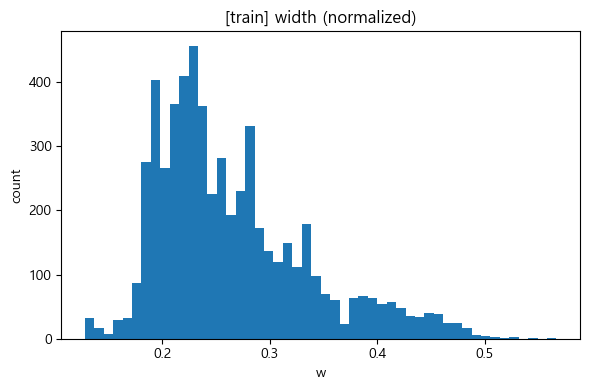

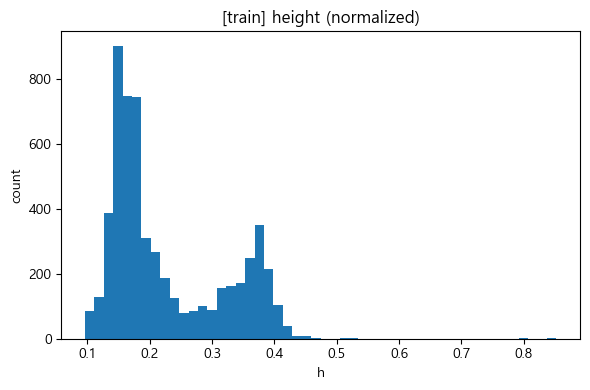

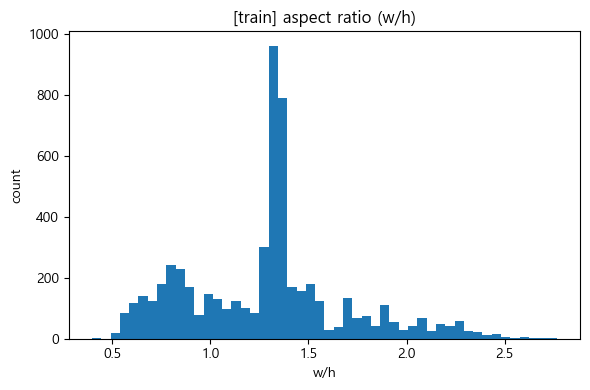

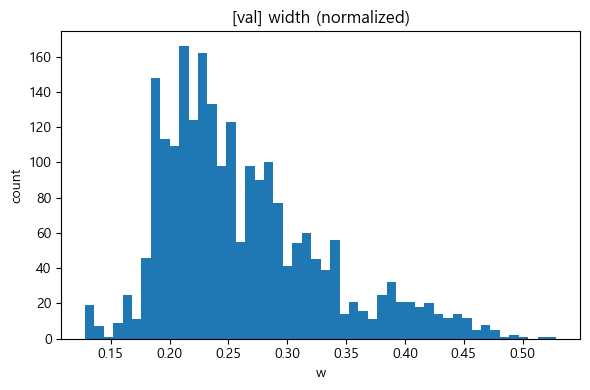

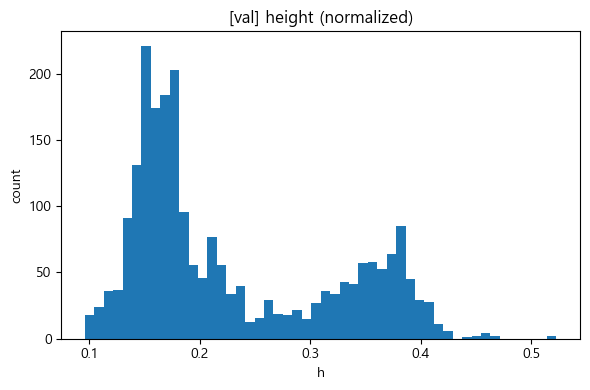

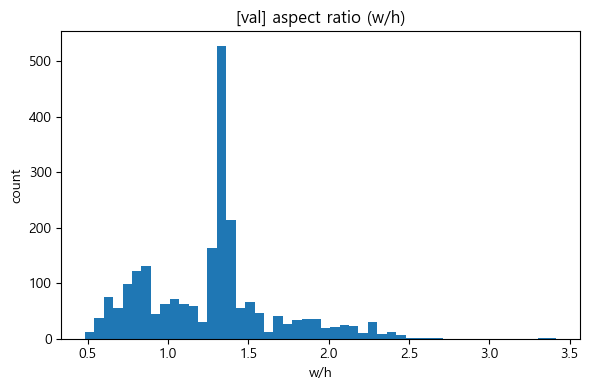

In [22]:
# ================================================================
# [4.2] YOLO bbox 크기/종횡비 분포
# ================================================================
import numpy as np
import matplotlib.pyplot as plt

def collect_yolo_boxes(split: str):
    wh, ar = [], []
    for stem, lines in iter_label_lines(LB_OUT / split):
        for ln in lines:
            parts = ln.split()
            if len(parts) < 5:
                continue
            try:
                _, cx, cy, w, h = parts[:5]
                w, h = float(w), float(h)
            except Exception:
                continue
            if 0 < w <= 1 and 0 < h <= 1:
                wh.append((w, h))
                ar.append(w / max(h, 1e-12))
    return np.array(wh), np.array(ar)

for split in ["train", "val"]:
    WH, AR = collect_yolo_boxes(split)
    if WH.size == 0:
        print(f"[{split}] 유효 bbox가 없어 히스토그램을 건너뜀.")
        continue

    plt.figure(figsize=(6, 4)); plt.hist(WH[:, 0], bins=50)
    plt.title(f"[{split}] width (normalized)"); plt.xlabel("w"); plt.ylabel("count"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4)); plt.hist(WH[:, 1], bins=50)
    plt.title(f"[{split}] height (normalized)"); plt.xlabel("h"); plt.ylabel("count"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4)); plt.hist(AR, bins=50)
    plt.title(f"[{split}] aspect ratio (w/h)"); plt.xlabel("w/h"); plt.ylabel("count"); plt.tight_layout(); plt.show()

    # (옵션) 너비-높이 산점도
    # plt.figure(figsize=(6, 5)); plt.scatter(WH[:, 0], WH[:, 1], s=6, alpha=0.3)
    # plt.title(f"[{split}] width vs height"); plt.xlabel("w"); plt.ylabel("h"); plt.tight_layout(); plt.show()


### [4.3] 빈 라벨(배경) 파일 목록 예시

In [23]:
# ================================================================
# [4.3] 배경(라벨 0개) 파일 예시
# ================================================================
def list_empty_files(split: str, k=20):
    lab_dir = LB_OUT / split
    empties = []
    for f in lab_dir.glob("*.txt"):
        txt = f.read_text(encoding="utf-8", errors="ignore").strip()
        if not txt:
            empties.append(f.stem)
    print(f"[{split}] empty labels: {len(empties)} (예시 {min(k,len(empties))}개)")
    print(empties[:k])

list_empty_files("train", k=20)
list_empty_files("val", k=20)


[train] empty labels: 417 (예시 20개)
['K-001866-013395-022627-044834_0_2_0_2_70_000_200', 'K-001866-013395-022627-044834_0_2_0_2_75_000_200', 'K-001866-013395-022627-044834_0_2_0_2_90_000_200', 'K-001866-013395-023223-037777_0_2_0_2_70_000_200', 'K-001866-013395-023223-037777_0_2_0_2_75_000_200', 'K-001866-013395-023223-037777_0_2_0_2_90_000_200', 'K-001866-013395-023223-044834_0_2_0_2_70_000_200', 'K-001866-013395-023223-044834_0_2_0_2_75_000_200', 'K-001866-013395-023223-044834_0_2_0_2_90_000_200', 'K-001866-019552-022362-037777_0_2_0_2_70_000_200', 'K-001866-019552-022362-037777_0_2_0_2_75_000_200', 'K-001866-019552-022362-037777_0_2_0_2_90_000_200', 'K-001866-019552-022362-038954_0_2_0_2_70_000_200', 'K-001866-019552-022362-038954_0_2_0_2_75_000_200', 'K-001866-019552-022362-038954_0_2_0_2_90_000_200', 'K-001866-022362-022627-037777_0_2_0_2_70_000_200', 'K-001866-022362-022627-037777_0_2_0_2_75_000_200', 'K-001866-022362-022627-037777_0_2_0_2_90_000_200', 'K-001866-022362-022627-0389

## 5. COCO vs YOLO 동기화 체크

In [24]:
# ================================================================
# [5.0] COCO vs YOLO 동기화 체크
#  - 전제: 1.x 단계 변수 재사용 권장
#  - 없으면 미니 로더로 대체 스캔
# ================================================================
import json, os
from collections import Counter
from pathlib import Path

# --- 정책 스위치 (COCO→YOLO 변환 시와 동일해야 비교가 정확) ---
EXCLUDE_GENERIC = False   # 85클래스로 본다면 False
GENERIC_NAMES   = {"Drug"}

# --- 스플릿 파일 로드 (2.5에서 저장됨) ---
train_list_file = YOLO_ROOT/"split_train.txt"
val_list_file   = YOLO_ROOT/"split_val.txt"
assert train_list_file.exists() and val_list_file.exists(), "split_train.txt / split_val.txt 이 필요합니다."

train_set = set(train_list_file.read_text(encoding="utf-8").splitlines())
val_set   = set(val_list_file.read_text(encoding="utf-8").splitlines())

# --- 1.x 변수 확인 & 미니 로더 준비 ---
NEED_MINI_LOAD = False
for need in ["img_to_anns", "img_info", "cat_id_rep_name"]:
    if need not in globals():
        NEED_MINI_LOAD = True
        break

if NEED_MINI_LOAD:
    print("ℹ️ 1.x 변수 없음 → COCO 최소 정보 재스캔(미니 로더)로 진행합니다.")
    DATA_NEW = Path(r"D:/datasets/data_new")
    IMG_DIR  = DATA_NEW / "train_images"
    ANN_DIR  = DATA_NEW / "train_annotations"
    assert ANN_DIR.exists() and IMG_DIR.exists(), "data_new/train_annotations, train_images 경로 확인"

    # 미니 로더: COCO json들을 훑어 이미지→어노테이션 매핑/대표명 매핑 복구
    img_to_anns = {}
    img_info    = {}
    cat_id_rep_name = {}

    def _canon(s):
        return str(s).strip().replace("（","(").replace("）",")")

    for jf in ANN_DIR.rglob("*.json"):
        try:
            data = json.loads(Path(jf).read_text(encoding="utf-8"))
        except:
            data = json.loads(Path(jf).read_text(encoding="cp949", errors="ignore"))
        images = data.get("images") or []
        anns   = data.get("annotations") or []
        cats   = data.get("categories") or []
        # 대표명 누적
        for c in cats:
            cid, nm = c.get("id"), _canon(c.get("name"))
            if cid is not None and nm:
                cat_id_rep_name.setdefault(cid, set()).add(nm)
        # id→file
        id2file = {}
        for im in images:
            fid, fn = im.get("id"), im.get("file_name")
            if fid is None or not fn: 
                continue
            id2file[fid] = fn
            img_info[fn] = {"width": im.get("width"), "height": im.get("height")}
        # 이미지별 어노테이션 적재
        for a in anns:
            iid = a.get("image_id")
            fn = id2file.get(iid)
            if not fn: 
                fn = a.get("file_name")  # 일부 케이스
            if not fn:
                continue
            img_to_anns.setdefault(fn, []).append(a)

    # 대표명 확정
    cat_id_rep_name = {cid: sorted(list(nset))[0] for cid, nset in cat_id_rep_name.items()}

def ann_name(ann):
    # 이름 우선 → 없으면 id 대표명 → 최후엔 'id:K'
    return ann.get("category_name") or cat_id_rep_name.get(ann.get("category_id"), f"id:{ann.get('category_id')}")

# --- COCO 기준: split별 유효 bbox 수 (정책 반영) ---
def coco_box_counts(file_names):
    by_cls = Counter()
    img_any_kept = set()
    img_all_dropped = set()
    for fn in file_names:
        kept = 0
        for a in img_to_anns.get(fn, []):
            cname = ann_name(a)
            if EXCLUDE_GENERIC and cname in GENERIC_NAMES:
                continue
            by_cls[cname] += 1
            kept += 1
        if kept > 0: img_any_kept.add(fn)
        else:        img_all_dropped.add(fn)
    return by_cls, img_any_kept, img_all_dropped

coco_tr_byname, tr_kept, tr_dropped = coco_box_counts(train_set)
coco_va_byname, va_kept, va_dropped = coco_box_counts(val_set)

print(f"COCO 기준(정책반영) bbox 수 - train:{sum(coco_tr_byname.values())}, val:{sum(coco_va_byname.values())}")
print(f"YOLO에서 '배경'이 된 이미지 수 추정 - train:{len(tr_dropped)}, val:{len(va_dropped)}")

# --- YOLO 기준: split별 bbox 수 (yid → name) ---
with open(YOLO_ROOT/"classes.txt", "r", encoding="utf-8") as f:
    cls_names = [ln.strip() for ln in f if ln.strip()]

def yolo_box_counts(split):
    used = Counter()
    for stem, lines in iter_label_lines(LB_OUT/split):
        for ln in lines:
            try:
                yid = int(float(ln.split()[0]))
            except:
                continue
            name = cls_names[yid] if 0 <= yid < len(cls_names) else f"id:{yid}"
            used[name] += 1
    return used

yolo_tr_byname = yolo_box_counts("train")
yolo_va_byname = yolo_box_counts("val")
print(f"YOLO 기준 bbox 수 - train:{sum(yolo_tr_byname.values())}, val:{sum(yolo_va_byname.values())}")

# --- 클래스별 차이 표 ---
def diff_top(coco_counter, yolo_counter, topk=15):
    all_keys = set(coco_counter) | set(yolo_counter)
    rows = []
    for k in all_keys:
        rows.append((k, coco_counter.get(k,0), yolo_counter.get(k,0), coco_counter.get(k,0)-yolo_counter.get(k,0)))
    df = pd.DataFrame(rows, columns=["name","coco_cnt","yolo_cnt","(coco-yolo)"])
    df = df.sort_values(by="(coco-yolo)", ascending=False)
    return df.head(topk), df.tail(topk)

print("\n[train] 클래스별 COCO vs YOLO 차이(상위/하위)")
tr_head, tr_tail = diff_top(coco_tr_byname, yolo_tr_byname, topk=15)
display(tr_head); display(tr_tail)

print("\n[val]  클래스별 COCO vs YOLO 차이(상위/하위)")
va_head, va_tail = diff_top(coco_va_byname, yolo_va_byname, topk=15)
display(va_head); display(va_tail)


COCO 기준(정책반영) bbox 수 - train:5937, val:1495
YOLO에서 '배경'이 된 이미지 수 추정 - train:0, val:0
YOLO 기준 bbox 수 - train:5710, val:2284

[train] 클래스별 COCO vs YOLO 차이(상위/하위)


name  coco_cnt  yolo_cnt  (coco-yolo)
28               Drug      1420         0         1420
37     글리틴정(콜린알포세레이트)        27        27            0
30        브린텔릭스정 20mg        12        12            0
31         렉사프로정 15mg        12        12            0
65        아빌리파이정 10mg        18        18            0
72        졸로푸트정 100mg        12        12            0
42  에빅사정(메만틴염산염)(비매품)        29        29            0
24      뮤코원캡슐(에르도스테인)         0         2           -2
14    리렉스펜정 300mg/PTP        36        38           -2
35    알바스테인캡슐(에르도스테인)         0         2           -2
23    아질렉트정(라사길린메실산염)        24        26           -2
45      엘스테인정(에르도스테인)         0         2           -2
29          글리아타민연질캡슐        27        30           -3
53               마도파정        24        28           -4
63          울트라셋이알서방정        42        47           -5

name  coco_cnt  yolo_cnt  (coco-yolo)
9               크레스토정 20mg       109       130          -21
43            세비카정 10/40mg        81       102          -21
41       무코스타정(레바미피드)(비매품)       102       123          -21
18              조인스정 200mg        36        58          -22
2             뉴로메드정(옥시라세탐)        24        48          -24
81            트라젠타정(리나글립틴)        75       101          -26
54            아토젯정 10/40mg       105       137          -32
48  종근당글리아티린연질캡슐(콜린알포세레이트)        24        56          -32
46                리바로정 4mg       107       140          -33
70             뮤테란캡슐 100mg       180       216          -36
17             일양하이트린정 2mg       235       276          -41
0              가바토파정 100mg       129       171          -42
80           동아가바펜틴정 800mg       132       190          -58
21              보령부스파정 5mg       156       237          -81
52      기넥신에프정(은행엽엑스)(수출용)       512       599          -87


[val]  클래스별 COCO vs YOLO 차이(상위/하위)


name  coco_cnt  yolo_cnt  (coco-yolo)
28                Drug       400         0          400
80          쿠에타핀정 25mg         6         6            0
24       뮤코원캡슐(에르도스테인)         0         1           -1
26        자이프렉사정 2.5mg         6         7           -1
10          카발린캡슐 25mg        15        16           -1
58  엘도스캡슐(에르도스테인)(수출용)         0         1           -1
30         브린텔릭스정 20mg         0         2           -2
31          렉사프로정 15mg         0         3           -3
36     알바스테인캡슐(에르도스테인)         0         3           -3
54                마도파정         6         9           -3
67         아빌리파이정 10mg         0         3           -3
74         졸로푸트정 100mg         0         3           -3
79       낙소졸정 500/20mg        15        19           -4
46       엘스테인정(에르도스테인)         0         4           -4
51       비모보정 500/20mg        15        19           -4

name  coco_cnt  yolo_cnt  (coco-yolo)
9           크레스토정 20mg        24        45          -21
71           리피토정 20mg        23        44          -21
4           자누비아정 50mg        12        34          -22
47            리바로정 4mg        30        53          -23
77          플라빅스정 75mg        15        43          -28
41   무코스타정(레바미피드)(비매품)        21        50          -29
55        아토젯정 10/40mg        33        62          -29
0          가바토파정 100mg        45        81          -36
72         뮤테란캡슐 100mg        42        80          -38
33        로수젯정10/5밀리그램         9        47          -38
1         뉴로메드정(옥시라세탐)         6        45          -39
82       동아가바펜틴정 800mg        42        81          -39
17         일양하이트린정 2mg        56       107          -51
21          보령부스파정 5mg        66       121          -55
53  기넥신에프정(은행엽엑스)(수출용)       105       198          -93